In [1]:
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=49e56fe418c72d3a74e7372b3333f57899aa9cb559d9f5af3ca7afcaf8ed077c
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [2]:
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=25d1d9b9d396d1f37cb5dc8f14d2622e7b0420920fcb38677931415d885e851d
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [3]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.0 MB/s eta 0:00:00


In [4]:
!pip install transformers

In [5]:
from google.colab import drive
import json
import re
from cleantext import clean
import emoji
import string
import datetime
import pandas as pd
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from autocorrect import Speller
import torch
from transformers import pipeline, BertTokenizer, BertForTokenClassification, BertTokenizerFast, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification,  T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification, AutoModelForTokenClassification, DistilBertTokenizer, DistilBertForQuestionAnswering
from gensim.models import LsiModel, LdaModel
from gensim import corpora
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [8]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [48]:
def load_json(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
  return data

def preprocess_text(text):
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs in multiline mode
  text = re.sub(r'\W', ' ', text) # Allow only word characters
  text = text.lower() # Convert to lowercase
  text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
  return text

def semi_preprocess_text(text):
  """Removes unnecessary urls, emails, emojis and preserves punctuation"""
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs in multiline mode
  # text = text.lower() # Convert to lowercase
  text = re.sub(r'\S*@\S*\s?',' ',text) # Remove emails
  text = emoji.replace_emoji(text, '') # Removes emojis but not emoticons
  # text = contractions.fix(text) # Expand contractions like don't to do not
  text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
  return text

def remove_one_letter_words(topic_set):
  return {word for word in topic_set if len(word) > 1}

def replace_misspelled_words(text, misspelled_words, correct_words):
  replacements = {'bengaluru': 'bangalore', 'blr': 'bangalore'}
  for i in range(len(misspelled_words)):
    text = re.sub(r'\b{0}\b'.format(misspelled_words[i]), correct_words[i], text, flags=re.IGNORECASE)
  return text

def prepare_data_for_analysis(json_file, city="default"):
  data = load_json(json_file)
  results = []
  for post in data:
    title = preprocess_text(post.get("title", ""))
    content = preprocess_text(post.get("post", ""))
    combined_text = f"{title} {content}"
    results.append({
        "city": city,
        "id": post["id"],
        "url": post["url"],
        "created_utc": post["created_utc"],
        "author": post["author"],
        "text": combined_text,
        "reddit_score": post["score"],
        "reddit_upvote_ratio": post["upvote_ratio"]})
  return results

def save_to_json(data, output_file):
  with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

In [10]:
def json_to_df(json_file_path):
  df = pd.read_json(json_file_path)
  return df

def load_reddit_json_to_df(json_file):
  with open(json_file, 'r') as file:
    data = json.load(file)
  records = []
  for post in data:
    records.append({
      'id': post['id'],
      'url': post['url'],
      'created_utc': post['created_utc'],
      'author': post['author'],
      'text': post['text'],
      'reddit_score': post['reddit_score'],
      'reddit_upvote_ratio': post['reddit_upvote_ratio']
    })
  return pd.DataFrame(records)

# Overall Post Sentiment

## Textblob

In [11]:
def sentiment_analysis_textblob(df_inp):
  df = df_inp.copy()
  sentiments = []
  for text in df['text']:
    analysis = TextBlob(text)
    sentiment_score = analysis.sentiment.polarity
    if sentiment_score > 0:
      sentiments.append('Positive')
    elif sentiment_score < 0:
      sentiments.append('Negative')
    else:
      sentiments.append('Neutral')
  df['textblob_sentiment'] = sentiments
  return df

## Vader

In [12]:
def sentiment_analysis_vader(df_inp):
  df = df_inp.copy()
  analyzer = SentimentIntensityAnalyzer()
  sentiments = []
  for text in df['text']:
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score > 0.05:
      sentiments.append('Positive')
    elif sentiment_score < -0.05:
      sentiments.append('Negative')
    else:
      sentiments.append('Neutral')
  df['vader_sentiment'] = sentiments
  return df

## Transformer

In [13]:
# distilbert/distilbert-base-uncased-finetuned-sst-2-english
def sentiment_analysis_transformer(df_inp):
  # tokenized_sentence = tokenizer.encode(test_sentence, padding=True, truncation=True,max_length=50, add_special_tokens = True)
  df = df_inp.copy()
  tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
  model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
  sentiment_labels = {0: "Negative", 1: "Positive"}
  sentiments = []
  limit = 512
  for text in df['text']:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=limit) # Limit the Tokens
    outputs = model(**inputs) # Instead of this we can also use sentiment-analysis pipeline
    probability = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probability, dim=1).item()
    sentiment_score = probability[0][predicted_class].item()
    sentiment = sentiment_labels[predicted_class]
    tol = 0.01
    if sentiment_score > 0.5 + tol or sentiment_score < 0.5 - tol:
      sentiments.append(sentiment)
    else:
      sentiments.append('Neutral')
  df['transformer_sentiment'] = sentiments
  return df

# Topic Modelling

## LDA

In [14]:
def topic_modeling_manual(df_inp, num_topics=10):
  df = df_inp.copy()
  vectorizer = CountVectorizer(max_features=5000, stop_words='english')
  X = vectorizer.fit_transform(df['text'])
  lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
  lda.fit(X)
  topics = lda.transform(X)
  topic_labels = [f"Topic {i}" for i in range(num_topics)]
  df['lda_manual_topic'] = topics.argmax(axis=1)
  return df, lda, vectorizer

def format_lda_manual_to_df(skl_lda_model, vectorizer_feature_names, top_n_words_per_topic=10):
  topics = []
  for topic_idx, topic in enumerate(skl_lda_model.components_):
    top_words = set([vectorizer_feature_names[i] for i in topic.argsort()[-top_n_words_per_topic:]]) # Extract top n words for the current topic
    topics.append({'lda_manual_topic': topic_idx, 'terms': top_words})
  topics_df = pd.DataFrame(topics)
  return topics_df

def straighten_sen(sentence_list):
  """A Function to convert list of preprocessed sentences into list of words"""
  return [word for sentence in sentence_list for word in sentence.strip().split()]

def nltk_preprocessing(stop, lemma, text):
  exclude_stop = [word for word in text.split() if word not in stop]
  standardize = [lemma.lemmatize(word) for word in exclude_stop]
  return standardize


def topic_modeling_lda_gensim(df_inp, num_topics=10):
  df = df_inp.copy()
  stop = set(nltk.corpus.stopwords.words('english'))
  lemma = nltk.stem.wordnet.WordNetLemmatizer() # standardize words like dogs to dog
  processed_texts = [nltk_preprocessing(stop, lemma, text) for text in df['text']]
  dictionary = corpora.dictionary.Dictionary(processed_texts) # Create a Gensim dictionary and corpus
  corpus = [dictionary.doc2bow(text) for text in processed_texts]
  lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=73, passes=10, alpha = 'auto', eta = 'auto', chunksize = 1000)
  dominant_topics = []
  for text_bow in corpus:
    topic_probs = lda_model.get_document_topics(text_bow)
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
    dominant_topics.append(dominant_topic)
  df['lda_genism_topic'] = dominant_topics # Assign dominant topics to each document
  return df, lda_model, dictionary

def format_lda_genism_to_df(topics_data):
  formatted_data = []
  for topic_id, terms in topics_data:
    term_list = set([term[0] for term in terms])
    formatted_data.append({'lda_genism_topic': topic_id, 'topics': term_list})
  return pd.DataFrame(formatted_data)

def extract_nouns(df_inp):
  df = df_inp.copy()
  nlp = spacy.load("en_core_web_lg")
  noun_dict = []
  for text in df['text']:
    doc = nlp(text)
    tokens = nltk.word_tokenize(text)
    # nouns_spacy = set([chunk.text for chunk in doc.noun_chunks if len(chunk.text.split()) <= 3])  # Extract noun phrases, straighten_sen()
    nouns_pos_tag = set([word for (word, pos) in nltk.pos_tag(tokens) if(pos[:2] == 'NN')])
    total_nouns = nouns_pos_tag # nouns_spacy.union(nouns_pos_tag)
    noun_dict.append(total_nouns)
  df['nouns'] = noun_dict
  return df

# Simple NER

In [17]:
def apply_simple_ner(df_inp):
  """Simple Named Entity Recognition"""
  df = df_inp.copy()
  nlp = spacy.load("en_core_web_sm")
  aspects = []
  for text in df['text']:
    doc = nlp(preprocess_text(text))
    aspects.extend([ent.text for ent in doc.ents])
  print("Top Entities Identified:")
  print(pd.Series(aspects).value_counts().head(10))

# ABSA

In [18]:
def perform_absa_deberta(df_inp, text_column, aspect_column):
  df = df_inp.copy()
  sentiments = []
  tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
  model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
  sent_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
  df['deberta_aspect_sentiment'] = df.apply( lambda row: {aspect:sent_classifier(row[text_column], text_pair=aspect)[0]['label'] if aspect in row[text_column].lower().split() else None for aspect in row[aspect_column]}, axis=1 )
  return df

In [19]:
def perform_absa_with_qa(df_inp, model, tokenizer, text_column, aspect_column, target_column_name="qa_aspect_sentiment"):
  df = df_inp.copy()
  sentiments = []
  qa_classifier = pipeline("question-answering", model=model, tokenizer=tokenizer)
  df[target_column_name] = df.apply( lambda row: {aspect:qa_classifier(question = f"How is {aspect}?", text_pair=aspect)['answer'] if aspect in row[text_column].lower().split() else None for aspect in row[aspect_column]}, axis=1 )
  return df

In [20]:
def summarize_aspects(df):
  """summarize Aspects using Flan-T5"""

  tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
  model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
  # Extract dominant topics and sentiments
  aspects = df.groupby('dominant_topic')['text'].apply(lambda x: ' '.join(x)).reset_index()
  summaries = []
  for _, row in aspects.iterrows():
    input_text = f"Summarize the following text: {row['text']}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model.generate(inputs.input_ids, max_length=150, num_beams=3, early_stopping=True)
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    summaries.append(summary)
  aspects['summary'] = summaries
  print("\nAspect Summaries:")
  for _, row in aspects.iterrows():
    print(f"\nTopic {row['dominant_topic']}:")
    print(f"Summary: {row['summary']}")
  return aspects

# Analysis

In [ ]:
def analyze_and_visualize(df, lda, vectorizer):
  """Sentiment Distribution of the posts"""
  plt.figure(figsize=(8, 6))
  df['bert_sentiment'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.7, label='BERT')
  df['roberta_sentiment'].value_counts().sort_index().plot(kind='bar', color='orange', alpha=0.7, label='RoBERTa')
  plt.title('Sentiment Distribution')
  plt.xlabel('Sentiment')
  plt.ylabel('Count')
  plt.legend()
  plt.show()

  feature_names = vectorizer.get_feature_names_out() #get word clouds for Topics
  for topic_idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(6, 6))
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
    plt.title(f'Topic {topic_idx}')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
def summarize_results(df):
  summary = {'total_posts': len(df),
      'bert_positive_posts': (df['bert_sentiment'] > 0).sum(),
      'bert_negative_posts': (df['bert_sentiment'] < 0).sum(),
      'bert_neutral_posts': (df['bert_sentiment'] == 0).sum(),
      'roberta_positive_posts': (df['roberta_sentiment'] > 0).sum(),
      'roberta_negative_posts': (df['roberta_sentiment'] < 0).sum(),
      'roberta_neutral_posts': (df['roberta_sentiment'] == 0).sum()}
  print("\nSummary of Results:")
  print(f"Total Posts: {summary['total_posts']}")
  print(f"BERT - Positive Posts: {summary['bert_positive_posts']}")
  print(f"BERT - Negative Posts: {summary['bert_negative_posts']}")
  print(f"BERT - Neutral Posts: {summary['bert_neutral_posts']}")
  print(f"RoBERTa - Positive Posts: {summary['roberta_positive_posts']}")
  print(f"RoBERTa - Negative Posts: {summary['roberta_negative_posts']}")
  print(f"RoBERTa - Neutral Posts: {summary['roberta_neutral_posts']}")

#Bangalore

In [21]:
bangalore_misspelled_words = ['bengaluru','blr']
bangalore_correct_words = ['bangalore', 'bangalore']

In [22]:
file_path = "/content/drive/MyDrive/Winter Project/data/New/processed_posts_bangalore.json"
bangalore_df = load_reddit_json_to_df(file_path)
bangalore_df['text'] = bangalore_df['text'].apply(replace_misspelled_words, args=(bangalore_misspelled_words, bangalore_correct_words))
bangalore_df_short = bangalore_df[["id", "text"]].copy()
bangalore_df_textblob = sentiment_analysis_textblob(bangalore_df_short)
bangalore_df_vader = sentiment_analysis_vader(bangalore_df_short)
bangalore_df_trans = sentiment_analysis_transformer(bangalore_df_short)
bangalore_df_trans

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

id                                               text  \
0    1hasdky  spotted a 500d bus in hennur hi guys strange q...   
1    1hari5i  sm krishna pioneer in transforming bangalore a...   
2    1haqupq  video auto driver harasses 20 year old student...   
3    1haicks  empire kormangala is the worst i had heard big...   
4    1haefzm  a day to remember today has been one of the wo...   
..       ...                                                ...   
685  1gfreoo  i had to pay a bribe for my license and i feel...   
686  1gflgen  bangalore yellow line safety clearance by dece...   
687  1gfldiq  feeling self conscious about your appearance o...   
688  1gfkhld  alert my dog ranaway from hsr extension layout...   
689  1gfk1zx  king charles and camilla were on a secret four...   

    transformer_sentiment  
0                Negative  
1                Positive  
2                Negative  
3                Negative  
4                Negative  
..                    ...  
685              Negative  
686              Negative  
687              Negative  
688              Negative  
689              Negative  

[690 rows x 3 columns]

In [23]:
bangalore_df_gensim, lda_gensim, dictionary_gensim = topic_modeling_lda_gensim(bangalore_df_short, num_topics=10)
bangalore_lda_genism = format_lda_genism_to_df(lda_gensim.show_topics(num_topics=10, num_words=15, log=False, formatted=False))
bangalore_df_lda = bangalore_df_gensim.join(bangalore_lda_genism.set_index('lda_genism_topic'), on = ['lda_genism_topic'], how = 'left', rsuffix = '')

bangalore_df_lda, lda_manual, vectorizer_lda_manual = topic_modeling_manual(bangalore_df_lda, num_topics=10)
tf_feature_names = vectorizer_lda_manual.get_feature_names_out()
bangalore_lda_manual = format_lda_manual_to_df(lda_manual, tf_feature_names, top_n_words_per_topic=15)
bangalore_df_lda = bangalore_df_lda.join(bangalore_lda_manual.set_index('lda_manual_topic'), on = ['lda_manual_topic'], how = 'left', rsuffix = '')

bangalore_df_total_topics = extract_nouns(bangalore_df_lda)

bangalore_df_total_topics['total_topics'] = bangalore_df_total_topics.apply(lambda row: row.topics.union(row.nouns).union(row.terms), axis = 1)
bangalore_df_total_topics = bangalore_df_total_topics.drop(['lda_manual_topic', 'lda_genism_topic', 'nouns', 'topics', 'terms'], axis = 1)
bangalore_df_total_topics['total_topics'] = bangalore_df_total_topics['total_topics'].apply(remove_one_letter_words)

In [23]:
all_unique_topics = set().union(*bangalore_df_total_topics['total_topics'])
all_unique_topics

{'confirmation',
 'reply',
 'hoping',
 'plates',
 'discrimination',
 'chill',
 'tips',
 'sonu',
 'storage',
 'treadmills',
 'fair',
 'redditers',
 'stuck',
 'lx',
 'indirangar',
 'empathy',
 'hidden',
 'cm',
 'tea',
 'palya',
 'pump',
 'andhra',
 'pleads',
 'recidency',
 'offs',
 'address',
 'professionals',
 'bunny',
 'hothu',
 'insist',
 'trading',
 'efforts',
 'closer',
 'fi',
 'person',
 'building',
 'premkumar',
 'looting',
 'colleagues',
 'mins',
 'clickbaity',
 'bachans',
 'burning',
 'ear',
 'cmo',
 'risk',
 'flea',
 'lifestyle',
 'rehabilitation',
 'hsr',
 'prassanna',
 'budget',
 'uttarakhand',
 'font',
 'vets',
 'holder',
 'purpose',
 'margin',
 'brunt',
 'duration',
 'bannerghatta',
 'partners',
 'heard',
 'narrative',
 'plastic',
 'escape',
 'thick',
 'spread',
 'documents',
 'relatives',
 'appreciation',
 'hearts',
 'nowineed',
 'duolingo',
 'bwssb',
 'farmer',
 'indie',
 'ka',
 'idde',
 'hostel',
 'living',
 'olx',
 'trauma',
 'tank',
 'hotels',
 'limitation',
 'kudos',


In [49]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

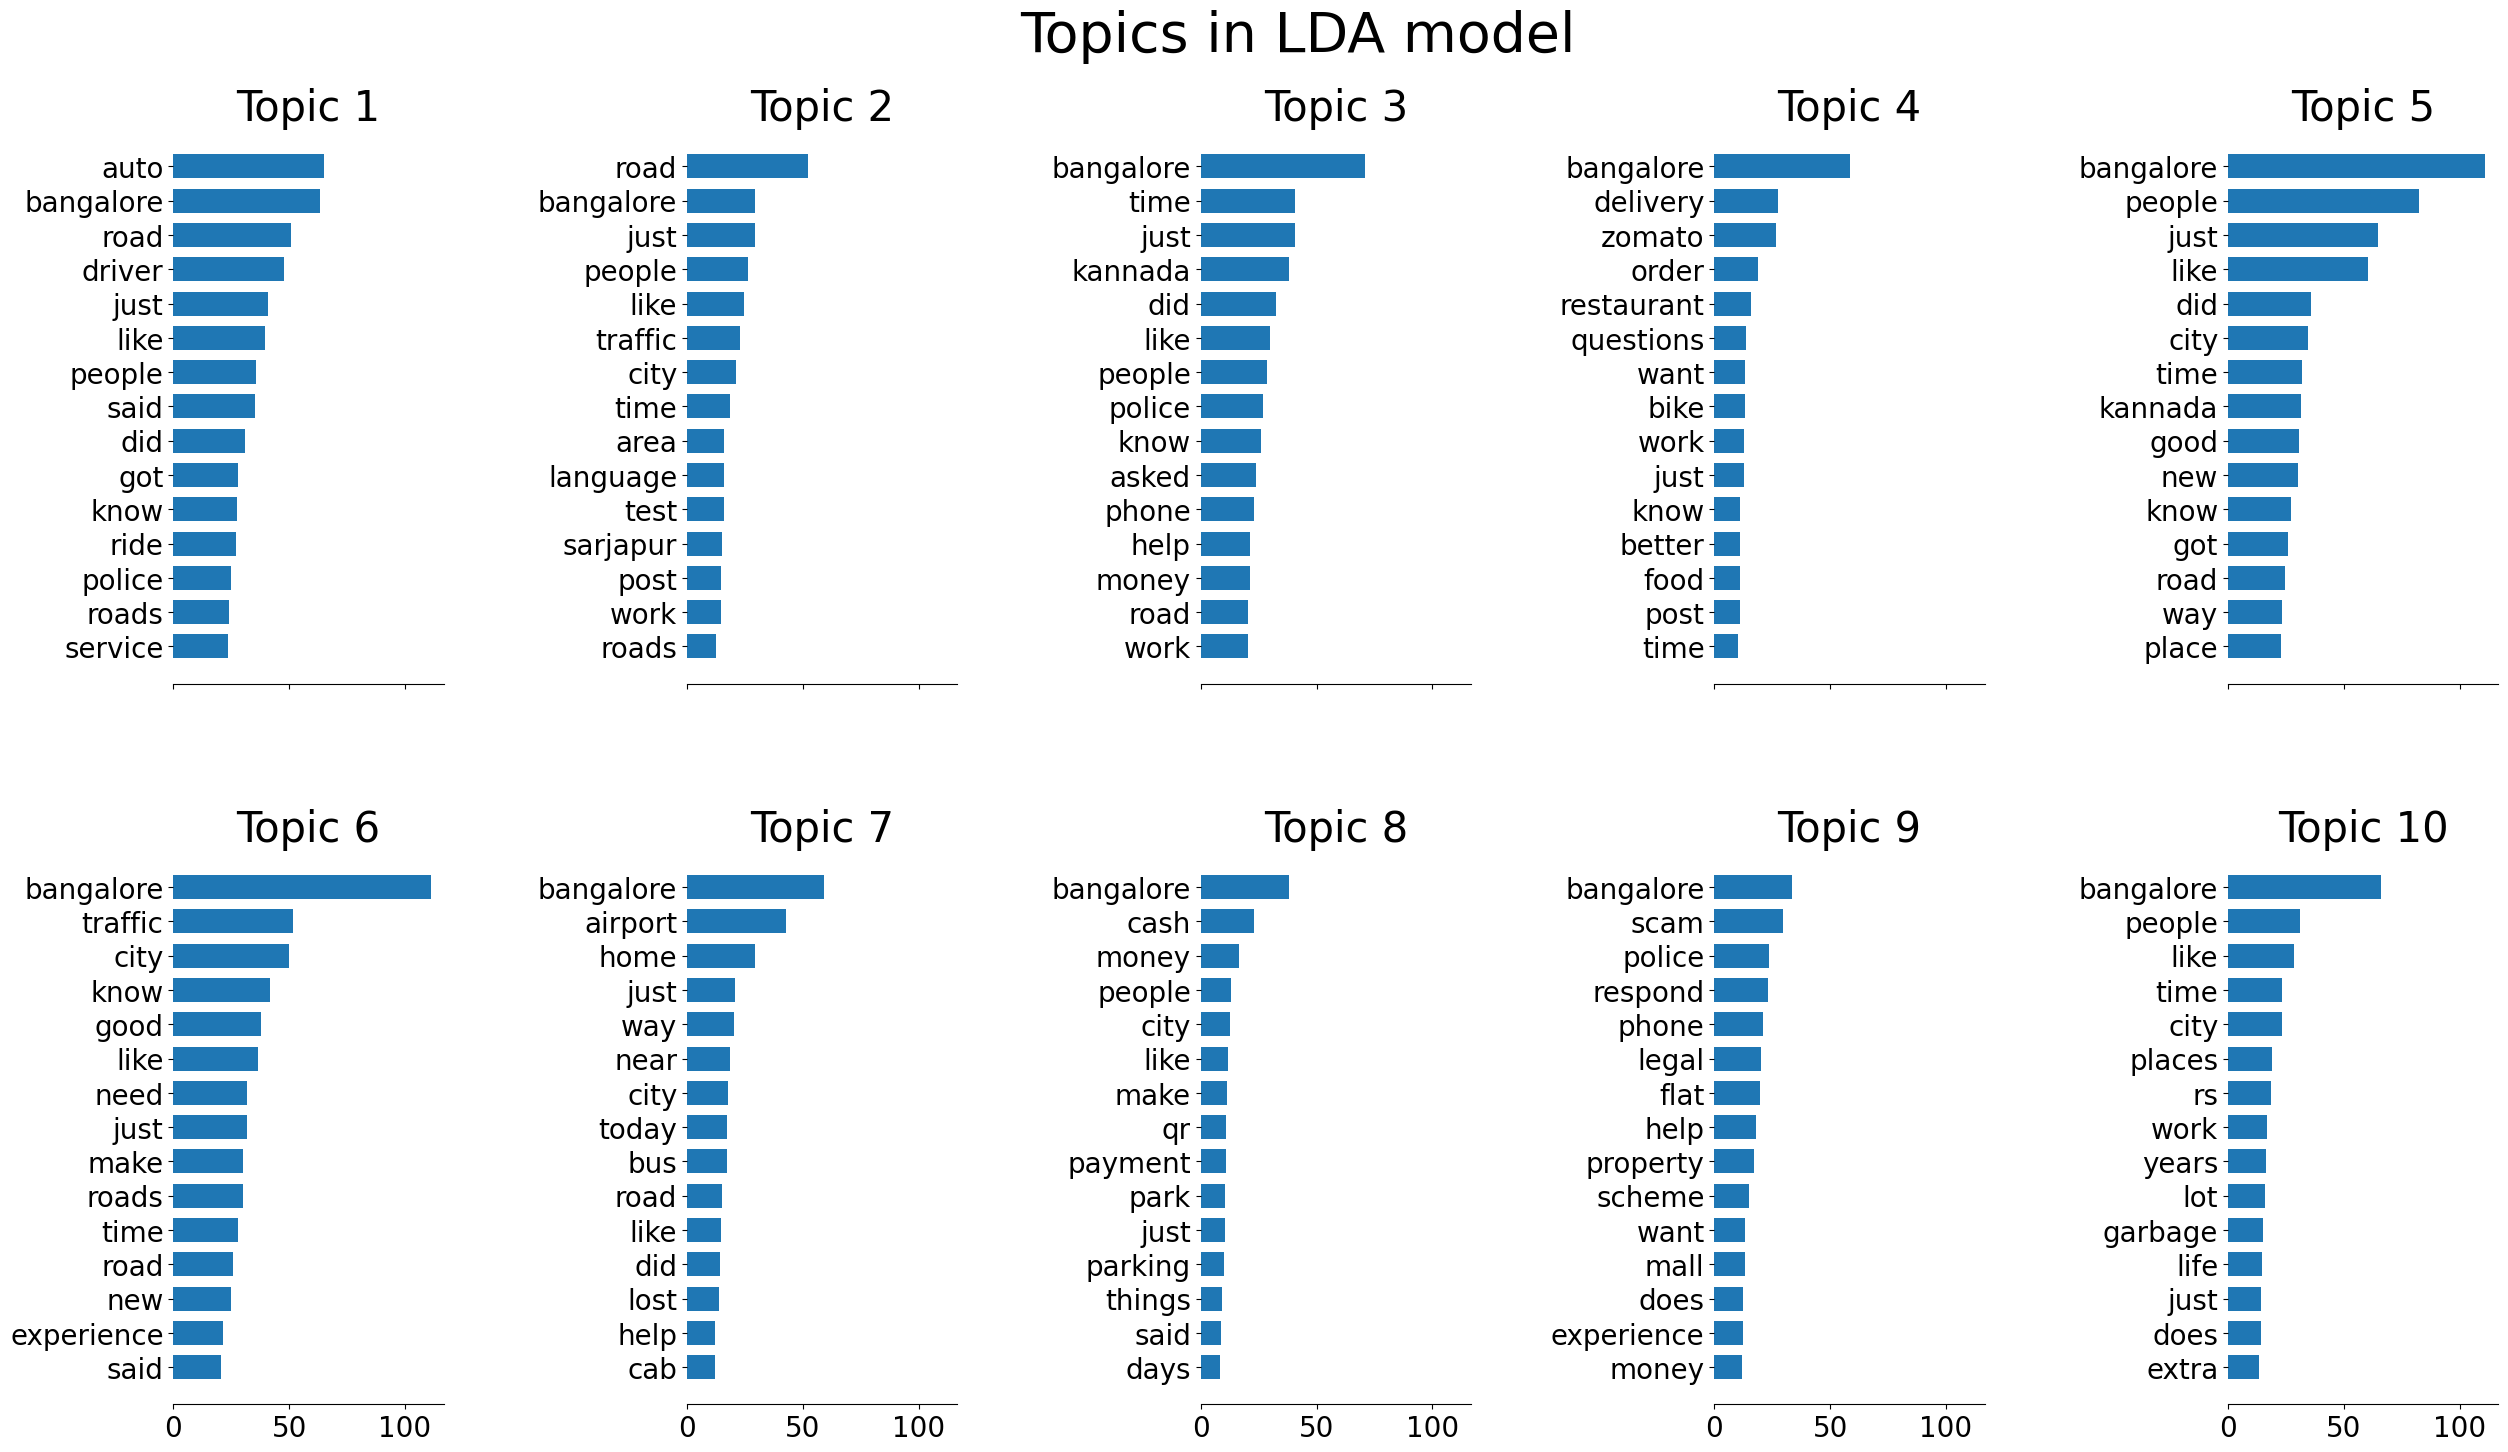

In [50]:
plot_top_words(lda_manual, tf_feature_names, 15, "Topics in LDA model")

In [51]:
# absa
raw_file_path = "/content/drive/MyDrive/Winter Project/data/New/raw_posts_bangalore.json"
bangalore_raw_df = json_to_df(raw_file_path) # load_reddit_json_to_df(raw_file_path)
bangalore_raw_df['text'] = bangalore_raw_df.apply( lambda row: semi_preprocess_text(row.title) + ". " + semi_preprocess_text(row.post), axis = 1)
bangalore_raw_df['text'] = bangalore_raw_df['text'].apply(replace_misspelled_words, args=(bangalore_misspelled_words, bangalore_correct_words))
bangalore_semi_df = bangalore_raw_df[['id', 'text']]
bangalore_semi_df

id                                               text
0    1hasdky  Spotted a 500D bus in hennur. Hi guys, strange...
1    1hari5i  SM Krishna, pioneer in transforming Bangalore ...
2    1haqupq  Video: Auto Driver Harasses 20-Year-Old Studen...
3    1haicks  Empire kormangala is the worst!. I had heard b...
4    1haefzm  A Day to remember!. Today has been one of the ...
..       ...                                                ...
685  1gfreoo  I had to pay a bribe for my license and I feel...
686  1gflgen  bangalore: Yellow Line safety clearance by Dec...
687  1gfldiq  Feeling self-conscious about your appearance o...
688  1gfkhld  Alert: My dog ranaway from HSR extension layou...
689  1gfk1zx  King Charles and Camilla were on a secret four...

[690 rows x 2 columns]

In [52]:
bangalore_semi_df = bangalore_semi_df.join(bangalore_df_total_topics.drop('text', axis = 1).set_index('id'), on = ['id'], how = 'left', rsuffix = '_right')
bangalore_semi_df

id                                               text  \
0    1hasdky  Spotted a 500D bus in hennur. Hi guys, strange...   
1    1hari5i  SM Krishna, pioneer in transforming Bangalore ...   
2    1haqupq  Video: Auto Driver Harasses 20-Year-Old Studen...   
3    1haicks  Empire kormangala is the worst!. I had heard b...   
4    1haefzm  A Day to remember!. Today has been one of the ...   
..       ...                                                ...   
685  1gfreoo  I had to pay a bribe for my license and I feel...   
686  1gflgen  bangalore: Yellow Line safety clearance by Dec...   
687  1gfldiq  Feeling self-conscious about your appearance o...   
688  1gfkhld  Alert: My dog ranaway from HSR extension layou...   
689  1gfk1zx  King Charles and Camilla were on a secret four...   

                                          total_topics  
0    {bagalur, take, people, thoughts, local, city,...  
1    {minister, people, system, aim, tax, govt, cit...  
2    {people, city, help, demands, one, just, banga...  
3    {everyone, people, biryani, city, words, place...  
4    {diarrhea, pharmacy, meters, prejudice, people...  
..                                                 ...  
685  {people, driving, city, want, process, asked, ...  
686  {people, city, safety, help, one, just, bus, b...  
687  {ideal, story, people, others, city, influence...  
688  {numbers, people, thank, word, city, pink, wan...  
689  {customer, king, people, city, help, one, cami...  

[690 rows x 3 columns]

In [53]:
bangalore_absa_deberta_df = perform_absa_deberta(bangalore_semi_df, text_column = 'text', aspect_column='total_topics')

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


In [54]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S")
save_path = f"/content/drive/MyDrive/Winter Project/data/DF Folder/absa_deberta_bangalore_{current_time}.json"
bangalore_absa_deberta_df.to_json(save_path, orient='records', lines=True)

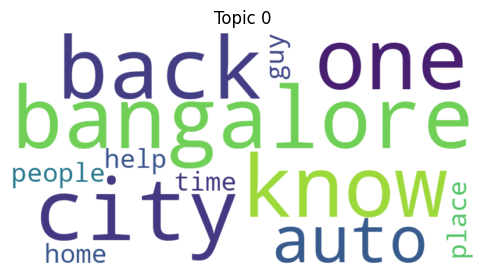

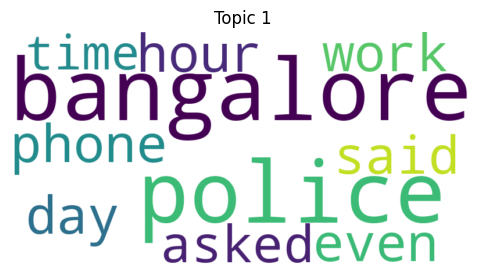

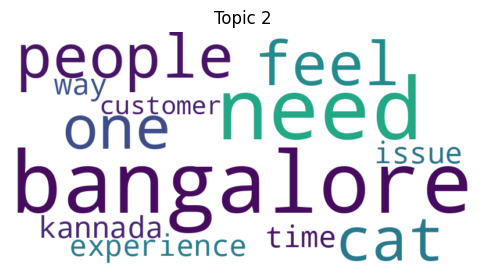

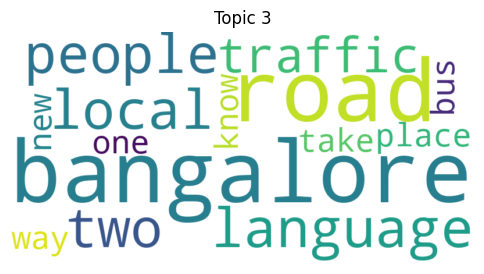

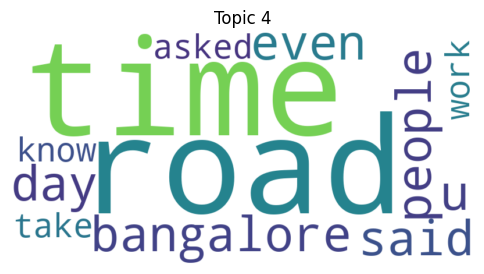

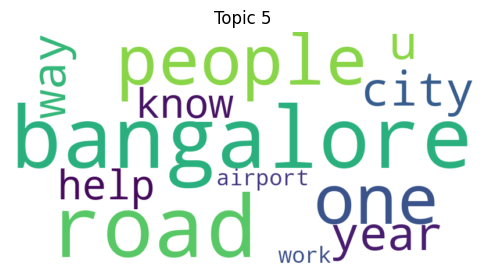

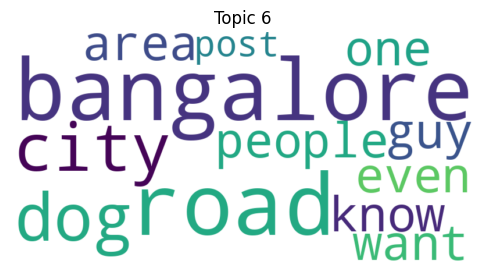

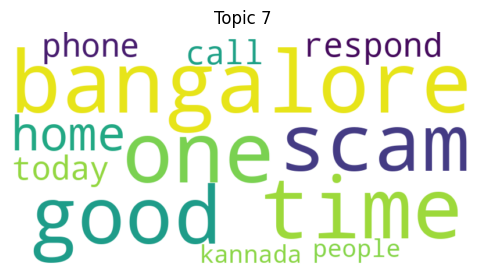

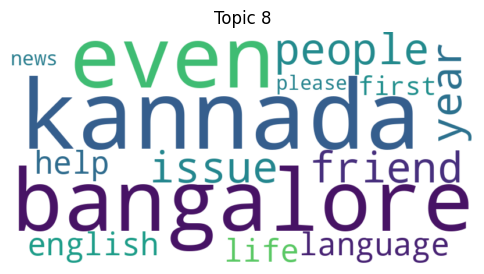

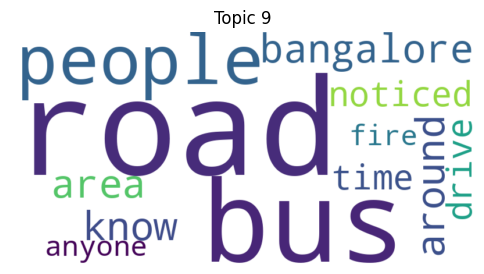

In [ ]:
for topic_idx in range(lda_gensim.num_topics):
  plt.figure(figsize=(6, 6))
  topic_terms = lda_gensim.show_topic(topic_idx, topn=15)
  wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join([word for word, _ in topic_terms]))
  plt.title(f'Topic {topic_idx}')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [ ]:
perform_absa_with_qa(bangalore_df)

In [ ]:
summarize_results(df)
apply_simple_ner(df)


Summary of Results:
Total Posts: 690
BERT - Positive Posts: 198
BERT - Negative Posts: 438
BERT - Neutral Posts: 54
RoBERTa - Positive Posts: 120
RoBERTa - Negative Posts: 289
RoBERTa - Neutral Posts: 281

Recommendations:
1. Focus on improving negative sentiment aspects identified in posts.
2. Enhance popular positive aspects to strengthen public opinion.
3. Address key topics identified in topic modeling, especially those with high negative sentiment.

Applying advanced NLP techniques such as Named Entity Recognition (NER) or Dependency Parsing.
Top Aspects Identified:
today      88
2          81
first      78
one        68
1          59
two        56
3          52
kannada    46
metro      38
india      37
Name: count, dtype: int64


In [ ]:
aspect_summaries = summarize_aspects_and_recommendations(df)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


Aspect Summaries and Recommendations:

Topic 0:
Summary: sm krishna a pioneer in transforming bangalore as silicon valley of india passed away today early morning

Topic 1:
Summary: today has been one of the worst days since I started living in bengaluru

Topic 2:
Summary: bangalore is the sole venue in the entire south for concerts and musical events

Topic 3:
Summary: Beware of scams in real estate

Topic 4:
Summary: video auto driver harasses 20 year old student in bengaluru demands extra fare another day


# Mumbai

In [71]:
mumbai_misspelled_words = ['bombay','mum']
mumbai_correct_words = ['mumbai', 'mumbai']

In [72]:
file_path = "/content/drive/MyDrive/Winter Project/data/New/processed_posts_mumbai.json"
mumbai_df = pd.read_json(file_path) # load_reddit_json_to_df(file_path)
mumbai_df['text'] = mumbai_df['text'].apply(replace_misspelled_words, args=(mumbai_misspelled_words, mumbai_correct_words))
mumbai_df_short = mumbai_df[["id", "text"]].copy()
mumbai_df_textblob = sentiment_analysis_textblob(mumbai_df_short)
mumbai_df_vader = sentiment_analysis_vader(mumbai_df_short)
mumbai_df_trans = sentiment_analysis_transformer(mumbai_df_short)
mumbai_df_trans

id                                               text  \
0    1hadzdp  looking for reasonable dentists around makabo ...   
1    1haed1u  swimming classes in vashi anyone knows swimmin...   
2    1hafpk7  three dead 20 injured after civic transport bu...   
3    1hag5di  best bhel puri vada pav chats in mumbai hi i a...   
4    1hagn54  need english tutor who can teach to native mar...   
..       ...                                                ...   
800  1gzk7y9  what is juhu and bandra like i am interested i...   
801  1gzh9rl  looking for a fancy restaurant for an annivers...   
802  1gzinga  mumbai in 1929 before marine drive and colaba ...   
803  1gzipcr  pan asian restaurant recommendations please he...   
804  1gziyms  where do i freshen up before a conference in s...   

    transformer_sentiment  
0                Negative  
1                Positive  
2                Negative  
3                Positive  
4                Negative  
..                    ...  
800              Positive  
801              Positive  
802              Negative  
803              Positive  
804              Negative  

[805 rows x 3 columns]

In [73]:
mumbai_df_gensim, mumbai_lda_gensim, mumbai_dictionary_gensim = topic_modeling_lda_gensim(mumbai_df_short, num_topics=10)
mumbai_lda_genism = format_lda_genism_to_df(mumbai_lda_gensim.show_topics(num_topics=10, num_words=15, log=False, formatted=False))
mumbai_df_lda = mumbai_df_gensim.join(mumbai_lda_genism.set_index('lda_genism_topic'), on = ['lda_genism_topic'], how = 'left', rsuffix = '')

mumbai_df_lda, mumbai_lda_manual, mumbai_vectorizer_lda_manual = topic_modeling_manual(mumbai_df_lda, num_topics=10)
mumbai_tf_feature_names = mumbai_vectorizer_lda_manual.get_feature_names_out()
mumbai_df_lda_manual = format_lda_manual_to_df(mumbai_lda_manual, mumbai_tf_feature_names, top_n_words_per_topic=15)
mumbai_df_lda = mumbai_df_lda.join(mumbai_df_lda_manual.set_index('lda_manual_topic'), on = ['lda_manual_topic'], how = 'left', rsuffix = '')

mumbai_df_total_topics = extract_nouns(mumbai_df_lda)

mumbai_df_total_topics['total_topics'] = mumbai_df_total_topics.apply(lambda row: row.topics.union(row.nouns).union(row.terms), axis = 1)
mumbai_df_total_topics = mumbai_df_total_topics.drop(['lda_manual_topic', 'lda_genism_topic', 'nouns', 'topics', 'terms'], axis = 1)
mumbai_df_total_topics['total_topics'] = mumbai_df_total_topics['total_topics'].apply(remove_one_letter_words)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
all_unique_topics = set().union(*mumbai_df_total_topics['total_topics'])
all_unique_topics

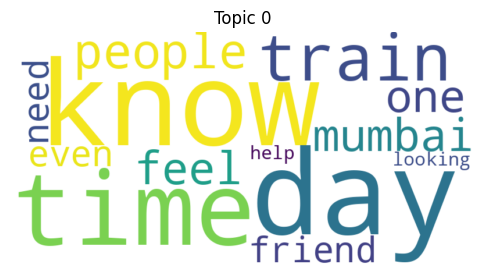

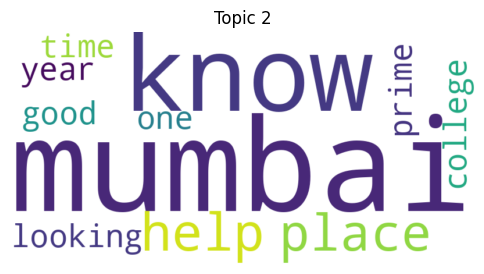

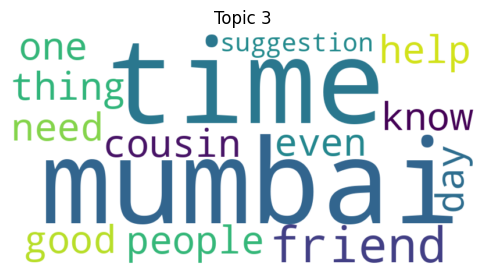

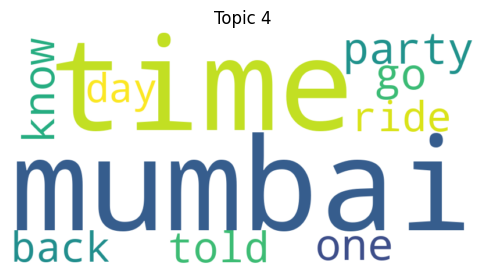

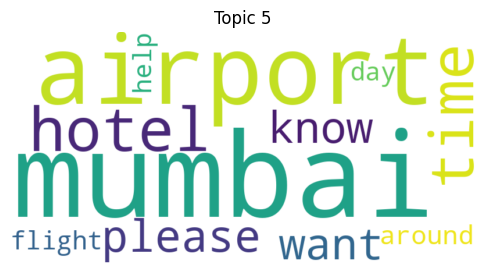

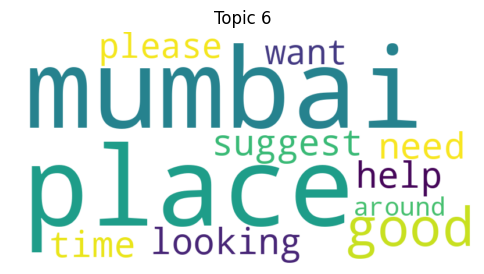

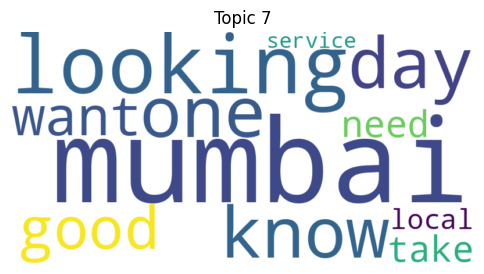

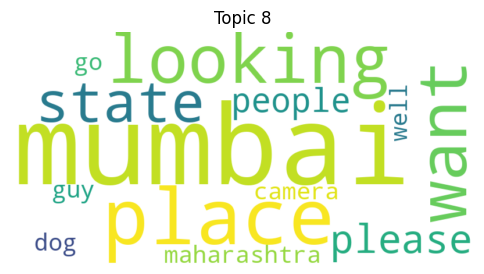

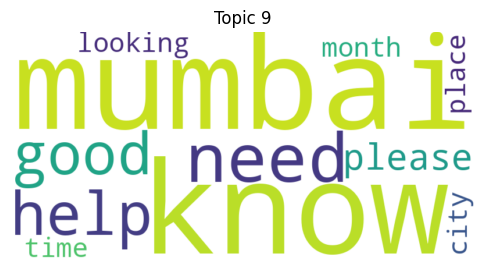

In [74]:
for topic_idx in range(mumbai_lda_gensim.num_topics):
  plt.figure(figsize=(6, 6))
  topic_terms = mumbai_lda_gensim.show_topic(topic_idx, topn=15)
  wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join([word for word, _ in topic_terms]))
  plt.title(f'Topic {topic_idx}')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [75]:
plot_top_words(mumbai_lda_manual, mumbai_tf_feature_names, 10, "Topics in LDA model")

In [76]:
# absa
raw_file_path = "/content/drive/MyDrive/Winter Project/data/New/raw_posts_mumbai.json"
mumbai_raw_df = json_to_df(raw_file_path) # load_reddit_json_to_df(raw_file_path)
mumbai_raw_df['text'] = mumbai_raw_df.apply( lambda row: semi_preprocess_text(row.title) + ". " + semi_preprocess_text(row.post), axis = 1)
mumbai_raw_df['text'] = mumbai_raw_df['text'].apply(replace_misspelled_words, args=(mumbai_misspelled_words, mumbai_correct_words))
mumbai_semi_df = mumbai_raw_df[['id', 'text']]
mumbai_semi_df

id                                               text
0    1hadzdp  Looking for reasonable dentists around MaKaBo....
1    1haed1u  Swimming classes in Vashi. Anyone knows swimmi...
2    1hafpk7  Three dead, 20 injured after civic transport b...
3    1hag5di  Best bhel puri / vada pav / chats in Mumbai. H...
4    1hagn54  Need English tutor who can teach to native Mar...
..       ...                                                ...
800  1gzk7y9  What is Juhu and Bandra like ?. I'm interested...
801  1gzh9rl  Looking for a fancy restaurant for an annivers...
802  1gzinga  Mumbai in 1929, Before marine drive and colaba...
803  1gzipcr  Pan asian restaurant recommendations please. H...
804  1gziyms  Where do I freshen up before a conference in S...

[805 rows x 2 columns]

In [77]:
mumbai_semi_df = mumbai_semi_df.join(mumbai_df_total_topics.drop('text', axis = 1).set_index('id'), on = ['id'], how = 'left', rsuffix = '_right')
mumbai_semi_df

id                                               text  \
0    1hadzdp  Looking for reasonable dentists around MaKaBo....   
1    1haed1u  Swimming classes in Vashi. Anyone knows swimmi...   
2    1hafpk7  Three dead, 20 injured after civic transport b...   
3    1hag5di  Best bhel puri / vada pav / chats in Mumbai. H...   
4    1hagn54  Need English tutor who can teach to native Mar...   
..       ...                                                ...   
800  1gzk7y9  What is Juhu and Bandra like ?. I'm interested...   
801  1gzh9rl  Looking for a fancy restaurant for an annivers...   
802  1gzinga  Mumbai in 1929, Before marine drive and colaba...   
803  1gzipcr  Pan asian restaurant recommendations please. H...   
804  1gziyms  Where do I freshen up before a conference in S...   

                                          total_topics  
0    {fixes, people, cap, min, city, couple, canal,...  
1    {people, fee, want, mumbai, good, adults, help...  
2    {house, vehicles, want, transport, mumbai, sug...  
3    {recommendations, city, want, chats, mumbai, s...  
4    {metro, people, tutor, want, goregoan, mumbai,...  
..                                                 ...  
800  {people, juhu, city, train, mumbai, help, one,...  
801  {husband, people, thank, dinner, juhu, city, f...  
802  {people, want, mumbai, railway, good, help, pl...  
803  {recommendations, want, mumbai, suggest, place...  
804  {everyone, metro, washrooms, people, hair, mal...  

[805 rows x 3 columns]

In [78]:
mumbai_absa_deberta_df = perform_absa_deberta(mumbai_semi_df, text_column = 'text', aspect_column='total_topics')

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


In [79]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S")
save_path = f"/content/drive/MyDrive/Winter Project/data/DF Folder/absa_deberta_mumbai_{current_time}.json"
mumbai_absa_deberta_df.to_json(save_path, orient='records', lines=True)

# Delhi

In [85]:
delhi_misspelled_words = ['del']
delhi_correct_words = ['delhi']

In [86]:
file_path = "/content/drive/MyDrive/Winter Project/data/New/processed_posts_delhi.json"
delhi_df = pd.read_json(file_path) # load_reddit_json_to_df(file_path)
delhi_df['text'] = delhi_df['text'].apply(replace_misspelled_words, args=(delhi_misspelled_words, delhi_correct_words))
delhi_df_short = delhi_df[["id", "text"]].copy()
delhi_df_textblob = sentiment_analysis_textblob(delhi_df_short)
delhi_df_vader = sentiment_analysis_vader(delhi_df_short)
delhi_df_trans = sentiment_analysis_transformer(delhi_df_short)
delhi_df_trans

id                                               text  \
0    1hatjex  girls of delhi where will i get warm bottom we...   
1    1hata9s  can anyone suggest better google map alternati...   
2    1haswaf  airbnb in delhi for solo traveler f my sister ...   
3    1haspjs  well life is not how i planned well life sucks...   
4    1hasoaq  your favourite street food spots to eat name o...   
..       ...                                                ...   
790  1h6gnrd  replay is here next year shall be dominated by...   
791  1h6gmj7                        share your spotify wrapped    
792  1h6giml  flew him out for a date on valentine s day and...   
793  1h6gfbz  meeting my friend at t3 of delhi airport my fr...   
794  1h6gbgd  is there any basketball or any sports group fo...   

    transformer_sentiment  
0                Negative  
1                Negative  
2                Positive  
3                Negative  
4                Positive  
..                    ...  
790              Positive  
791              Positive  
792              Positive  
793              Positive  
794              Negative  

[795 rows x 3 columns]

In [87]:
delhi_df_gensim, delhi_lda_gensim, delhi_dictionary_gensim = topic_modeling_lda_gensim(delhi_df_short, num_topics=10)
delhi_lda_genism = format_lda_genism_to_df(delhi_lda_gensim.show_topics(num_topics=10, num_words=15, log=False, formatted=False))
delhi_df_lda = delhi_df_gensim.join(delhi_lda_genism.set_index('lda_genism_topic'), on = ['lda_genism_topic'], how = 'left', rsuffix = '')

delhi_df_lda, delhi_lda_manual, delhi_vectorizer_lda_manual = topic_modeling_manual(delhi_df_lda, num_topics=10)
delhi_tf_feature_names = delhi_vectorizer_lda_manual.get_feature_names_out()
delhi_df_lda_manual = format_lda_manual_to_df(delhi_lda_manual, delhi_tf_feature_names, top_n_words_per_topic=15)
delhi_df_lda = delhi_df_lda.join(delhi_df_lda_manual.set_index('lda_manual_topic'), on = ['lda_manual_topic'], how = 'left', rsuffix = '')

delhi_df_total_topics = extract_nouns(delhi_df_lda)

delhi_df_total_topics['total_topics'] = delhi_df_total_topics.apply(lambda row: row.topics.union(row.nouns).union(row.terms), axis = 1)
delhi_df_total_topics = delhi_df_total_topics.drop(['lda_manual_topic', 'lda_genism_topic', 'nouns', 'topics', 'terms'], axis = 1)
delhi_df_total_topics['total_topics'] = delhi_df_total_topics['total_topics'].apply(remove_one_letter_words)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [89]:
all_unique_topics = set().union(*delhi_df_total_topics['total_topics'])
all_unique_topics

{'metro',
 'behaves',
 'laugh',
 'diagnosis',
 'chajja',
 'gay',
 'infront',
 'hindi',
 'city',
 'participation',
 'phoneuntil',
 'sopa',
 'androidland',
 'cool',
 'oh',
 'fine',
 'kumar',
 'gatorade',
 'shivam',
 'manner',
 'lalbagh',
 'hunt',
 'context',
 'रह',
 'task',
 'escalation',
 'travelers',
 'secure',
 'siddha',
 'type',
 'bengalis',
 'sunday',
 'dhaula',
 'skin',
 'hoti',
 'shame',
 'pushpa2',
 'godoli',
 'drawer',
 'hate',
 'chair',
 'belts',
 'genitalia',
 'andar',
 'chain',
 'articles',
 'overnight',
 'patients',
 'nurses',
 'feb',
 'ladaaku',
 'lifestyles',
 'kia',
 'loud',
 'kala',
 'theobroma',
 'खद',
 'airspace',
 'fight',
 'langas',
 'kuan',
 'palace',
 'committee',
 'typescript',
 'goer',
 'chodd',
 'crowds',
 'bills',
 'chilla',
 'serenity',
 'region',
 'developments',
 'procedures',
 'donors',
 'sweaters',
 'yo',
 'mess',
 'fruit',
 'shit',
 'pehle',
 'saw',
 'sewer',
 'rusk',
 'flights',
 'practices',
 'brownies',
 'anyway',
 'everyday',
 'professionals',
 'green

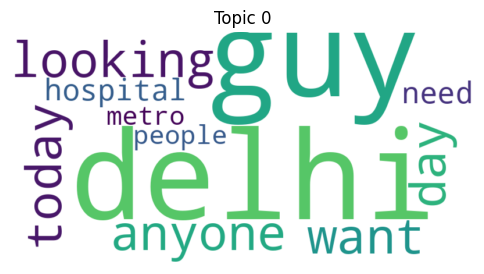

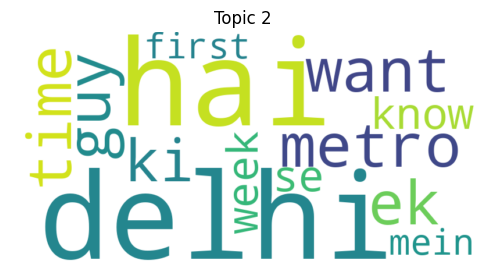

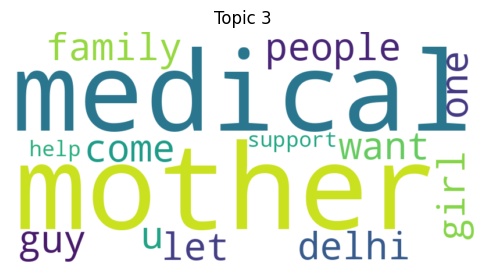

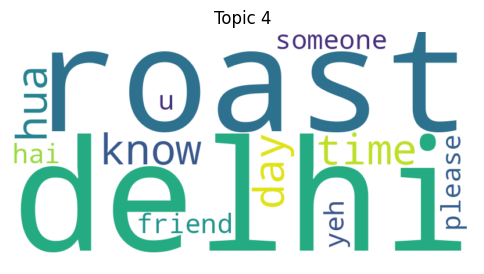

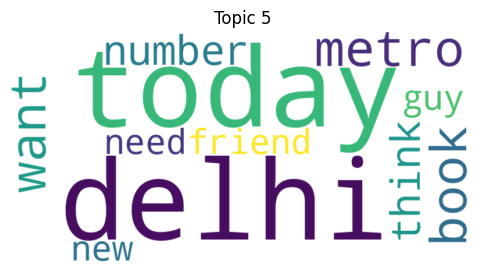

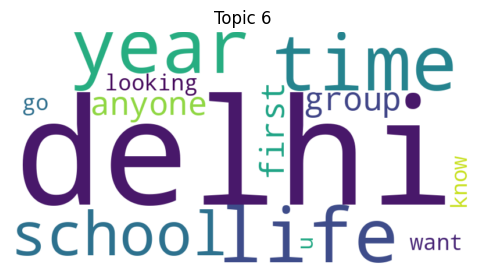

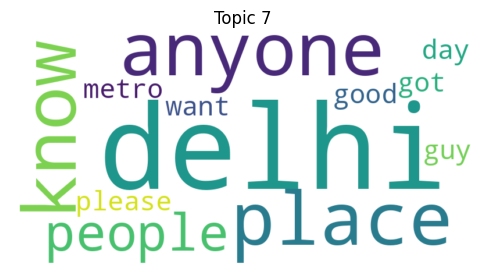

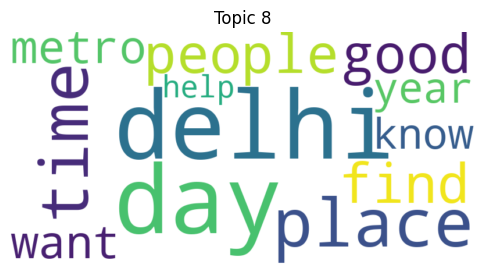

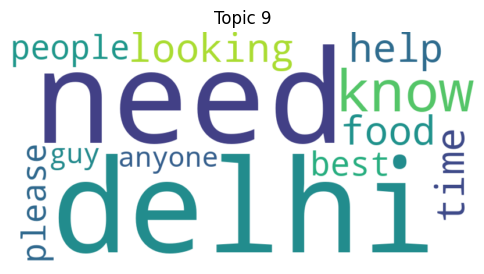

In [88]:
for topic_idx in range(delhi_lda_gensim.num_topics):
  plt.figure(figsize=(6, 6))
  topic_terms = delhi_lda_gensim.show_topic(topic_idx, topn=15)
  wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join([word for word, _ in topic_terms]))
  plt.title(f'Topic {topic_idx}')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

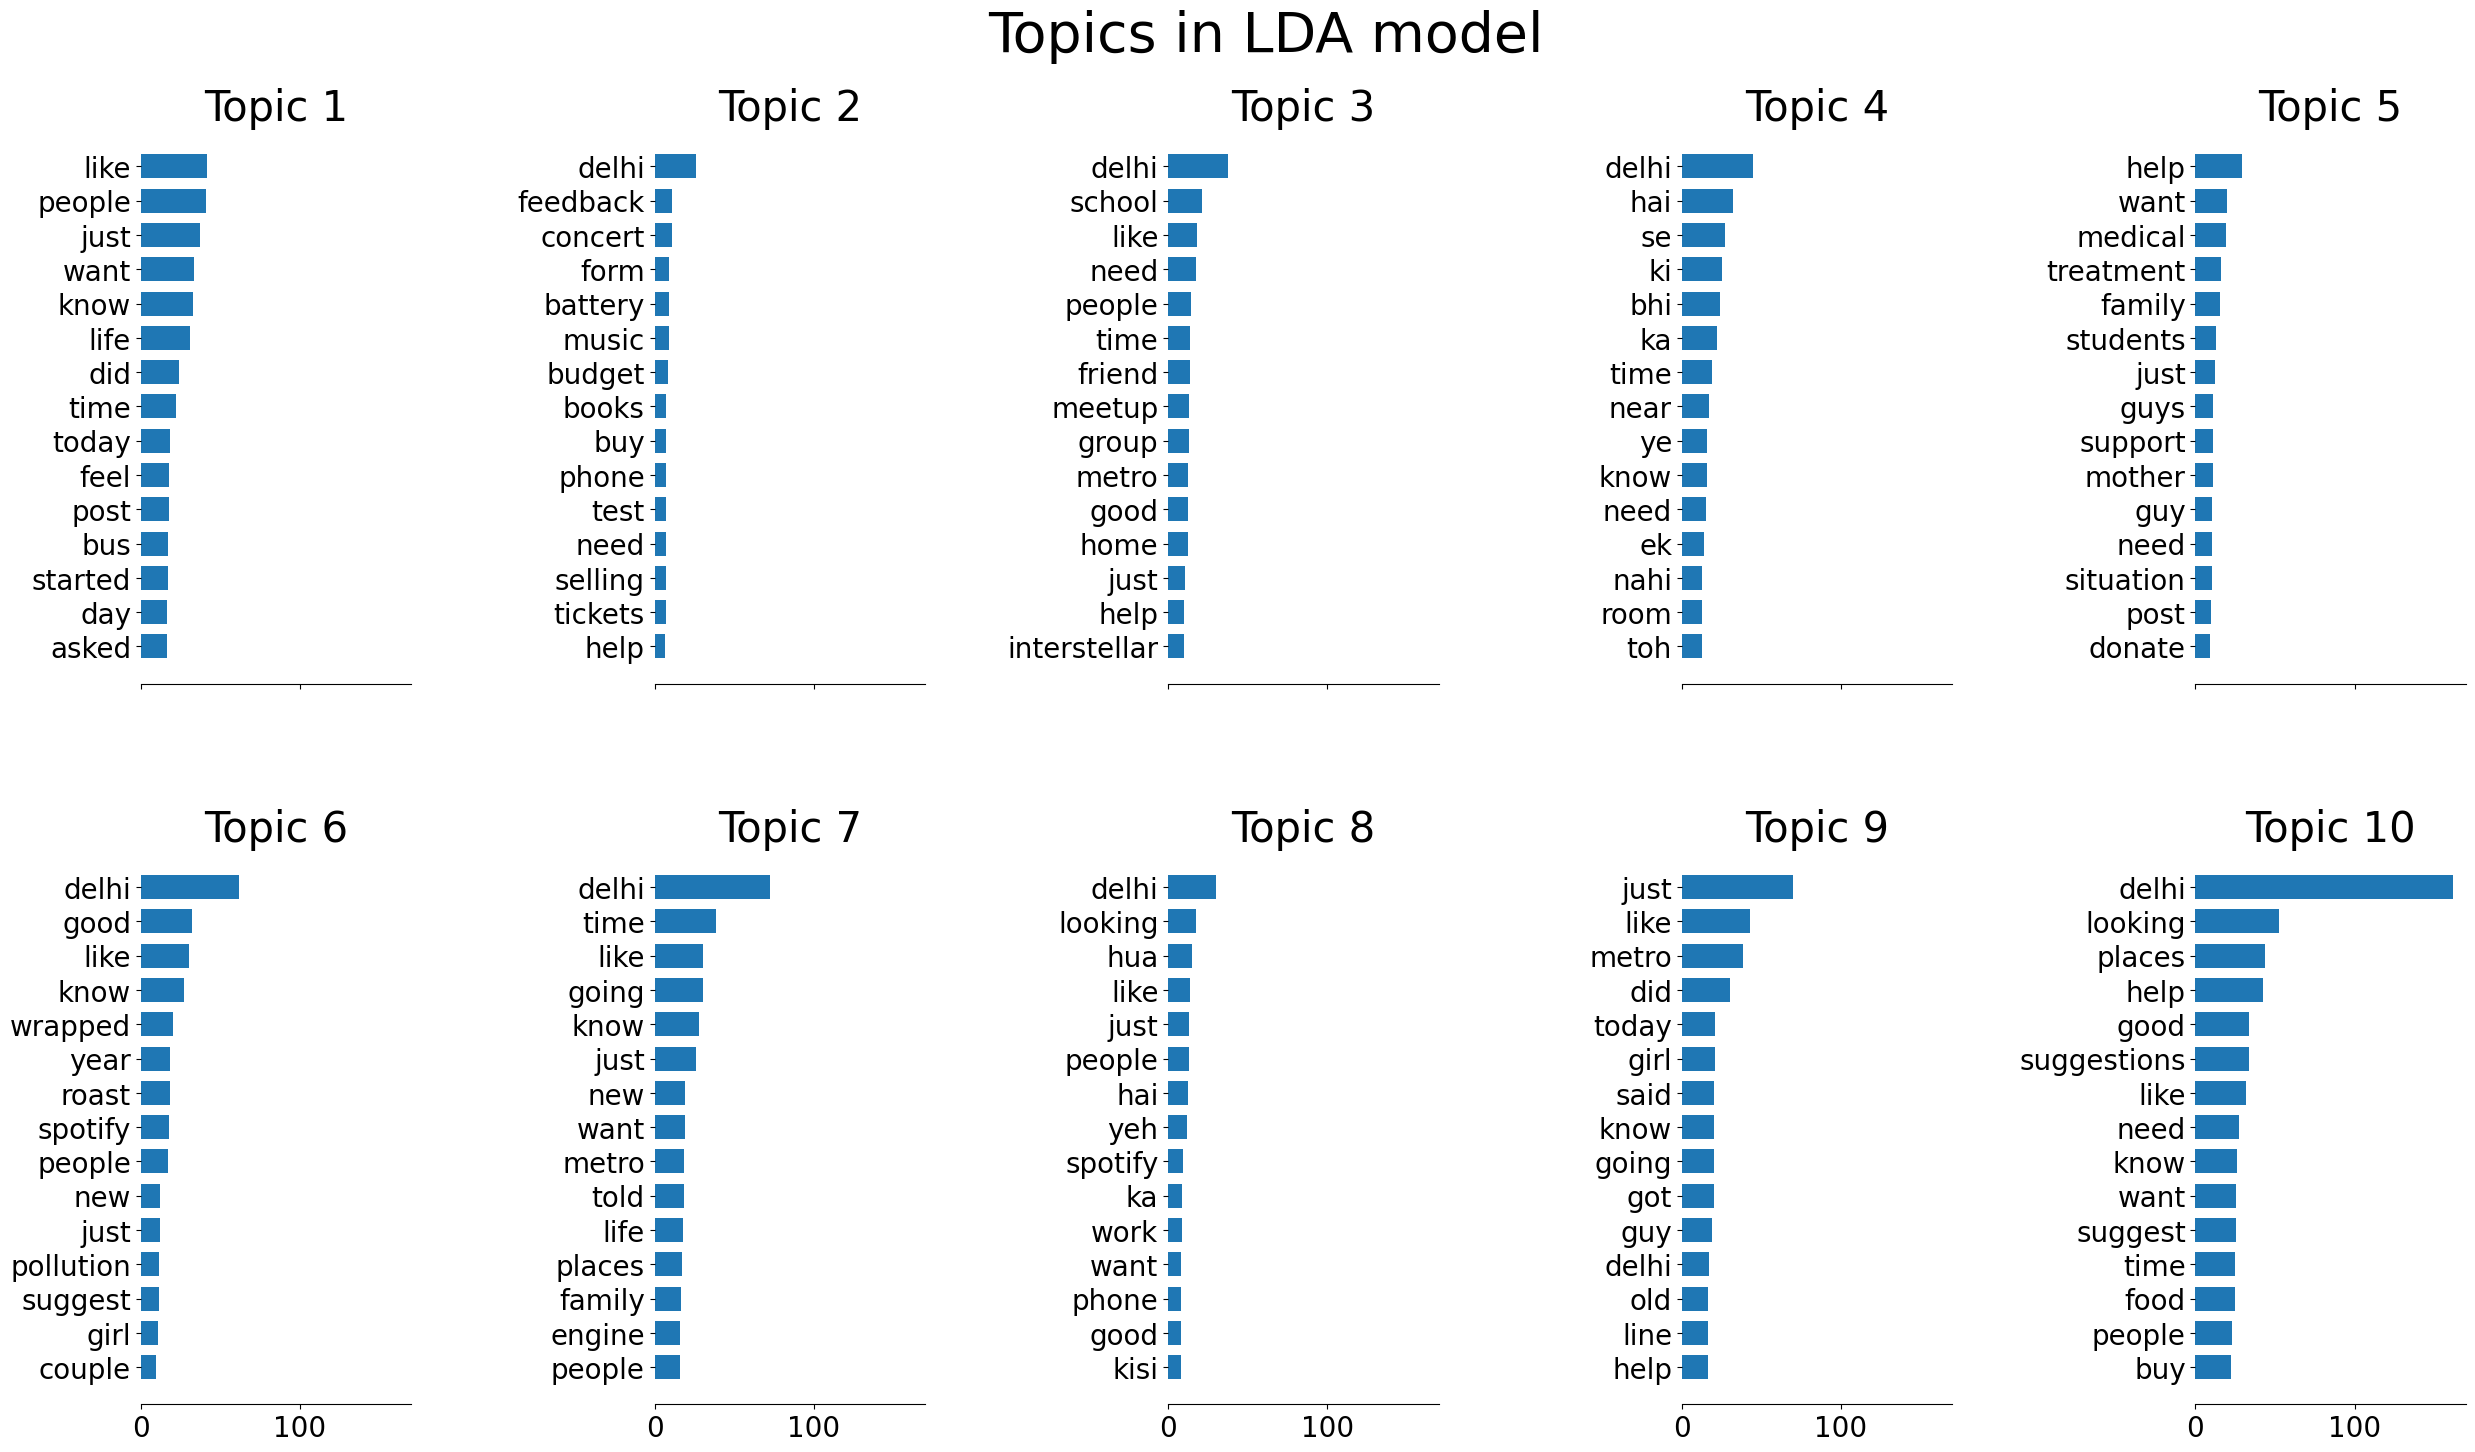

In [90]:
plot_top_words(delhi_lda_manual, delhi_tf_feature_names, 15, "Topics in LDA model")

In [97]:
# absa
raw_file_path = "/content/drive/MyDrive/Winter Project/data/New/raw_posts_delhi.json"
delhi_raw_df = json_to_df(raw_file_path) # load_reddit_json_to_df(raw_file_path)
delhi_raw_df['text'] = delhi_raw_df.apply( lambda row: semi_preprocess_text(row.title) + ". " + semi_preprocess_text(row.post), axis = 1)
delhi_raw_df['text'] = delhi_raw_df['text'].apply(replace_misspelled_words, args=(delhi_misspelled_words, delhi_correct_words))
delhi_semi_df = delhi_raw_df[['id', 'text']]
delhi_semi_df

id                                               text
0    1hatjex  Girls of Delhi , where will I get warm bottom ...
1    1hata9s  Can anyone suggest better Google map alternati...
2    1haswaf  AirBnB in Delhi for solo traveler (F). My sist...
3    1haspjs  Well, life isn't how I planned.. Well life suc...
4    1hasoaq  Your Favourite street food spots to eat. name ...
..       ...                                                ...
790  1h6gnrd  replay is here, next year shall be dominated b...
791  1h6gmj7                       Share your Spotify wrapped. 
792  1h6giml  Flew him out for a date on valentine's day, an...
793  1h6gfbz  Meeting my friend at T3 of delhi airport. My f...
794  1h6gbgd  Is there any basketball or any sports group fo...

[795 rows x 2 columns]

In [98]:
delhi_semi_df = delhi_semi_df.join(delhi_df_total_topics.drop('text', axis = 1).set_index('id'), on = ['id'], how = 'left', rsuffix = '_right')
delhi_semi_df

id                                               text  \
0    1hatjex  Girls of Delhi , where will I get warm bottom ...   
1    1hata9s  Can anyone suggest better Google map alternati...   
2    1haswaf  AirBnB in Delhi for solo traveler (F). My sist...   
3    1haspjs  Well, life isn't how I planned.. Well life suc...   
4    1hasoaq  Your Favourite street food spots to eat. name ...   
..       ...                                                ...   
790  1h6gnrd  replay is here, next year shall be dominated b...   
791  1h6gmj7                       Share your Spotify wrapped.    
792  1h6giml  Flew him out for a date on valentine's day, an...   
793  1h6gfbz  Meeting my friend at T3 of delhi airport. My f...   
794  1h6gbgd  Is there any basketball or any sports group fo...   

                                          total_topics  
0    {people, bottom, want, buy, suggest, yeh, plac...  
1    {point, first, people, school, want, asked, an...  
2    {metro, people, advance, want, female, hotels,...  
3    {metro, people, thoughts, want, meds, earn, id...  
4    {books, tickets, battery, buy, yeh, spots, hel...  
..                                                 ...  
790  {replay, metro, people, ki, want, find, nahi, ...  
791  {people, wrapped, pollution, couple, want, sug...  
792  {story, confidence, people, faith, city, want,...  
793  {metro, people, school, want, good, help, buil...  
794  {people, school, want, games, buy, suggest, pl...  

[795 rows x 3 columns]

In [99]:
delhi_absa_deberta_df = perform_absa_deberta(delhi_semi_df, text_column = 'text', aspect_column='total_topics')

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


In [100]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S")
save_path = f"/content/drive/MyDrive/Winter Project/data/DF Folder/absa_deberta_delhi_{current_time}.json"
delhi_absa_deberta_df.to_json(save_path, orient='records', lines=True)

# Visakhapatnam

In [134]:
vizag_misspelled_words = ['visakhapatnam', 'vishakhapatnam']
vizag_correct_words = ['vizag', 'vizag']

In [135]:
file_path = "/content/drive/MyDrive/Winter Project/data/New/processed_posts_visakhapatnam.json"
vizag_df = pd.read_json(file_path) # load_reddit_json_to_df(file_path)
vizag_df['text'] = vizag_df['text'].apply(replace_misspelled_words, args=(vizag_misspelled_words, vizag_correct_words))
vizag_df_short = vizag_df[["id", "text"]].copy()
vizag_df_textblob = sentiment_analysis_textblob(vizag_df_short)
vizag_df_vader = sentiment_analysis_vader(vizag_df_short)
vizag_df_trans = sentiment_analysis_transformer(vizag_df_short)
vizag_df_trans

id                                               text  \
0    1hapq8w  left the city in 2006 visited once in 2015 nev...   
1    1hak04f  cheap second hand phone hello looking for a se...   
2    1haj44e  planning to sell our 25 old flat 900 sft what ...   
3    1habvke  how to make friends in vizag i am not new to v...   
4    1ha9b17  kittens for adoption hi everyone i have a cat ...   
..       ...                                                ...   
916  1em8q0g  the sorta sunsets that kept me sane at home du...   
917  1em8mtp  looking for swing set hello vizagites i want t...   
918  1em7r9n  tulasidalam where can one watch the old tulasi...   
919  1em6fd4  need help in finding room pg hello guys i need...   
920  1em5x9s  clash between students on road causing chaos a...   

    transformer_sentiment  
0                Negative  
1                Negative  
2                Negative  
3                Negative  
4                Positive  
..                    ...  
916              Positive  
917              Negative  
918              Negative  
919              Negative  
920              Negative  

[921 rows x 3 columns]

In [136]:
vizag_df_gensim, vizag_lda_gensim, vizag_dictionary_gensim = topic_modeling_lda_gensim(vizag_df_short, num_topics=10)
vizag_lda_genism = format_lda_genism_to_df(vizag_lda_gensim.show_topics(num_topics=10, num_words=15, log=False, formatted=False))
vizag_df_lda = vizag_df_gensim.join(vizag_lda_genism.set_index('lda_genism_topic'), on = ['lda_genism_topic'], how = 'left', rsuffix = '')

vizag_df_lda, vizag_lda_manual, vizag_vectorizer_lda_manual = topic_modeling_manual(vizag_df_lda, num_topics=10)
vizag_tf_feature_names = vizag_vectorizer_lda_manual.get_feature_names_out()
vizag_df_lda_manual = format_lda_manual_to_df(vizag_lda_manual, vizag_tf_feature_names, top_n_words_per_topic=15)
vizag_df_lda = vizag_df_lda.join(vizag_df_lda_manual.set_index('lda_manual_topic'), on = ['lda_manual_topic'], how = 'left', rsuffix = '')

vizag_df_total_topics = extract_nouns(vizag_df_lda)

vizag_df_total_topics['total_topics'] = vizag_df_total_topics.apply(lambda row: row.topics.union(row.nouns).union(row.terms), axis = 1)
vizag_df_total_topics = vizag_df_total_topics.drop(['lda_manual_topic', 'lda_genism_topic', 'nouns', 'topics', 'terms'], axis = 1)
vizag_df_total_topics['total_topics'] = vizag_df_total_topics['total_topics'].apply(remove_one_letter_words)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [137]:
all_unique_topics = set().union(*vizag_df_total_topics['total_topics'])
print(len(all_unique_topics))
all_unique_topics

3593


{'ivvaleda',
 'metro',
 'pale',
 'fellow',
 'hindi',
 'city',
 'fry',
 'participation',
 'sellers',
 'notifications',
 'cool',
 'images',
 'fine',
 'damn',
 'correctness',
 'vacuum',
 'mayo',
 'maybe',
 'task',
 'olx',
 'secure',
 'nose',
 'type',
 'raises',
 'rushikonda',
 'dating',
 'sunday',
 'zero',
 'flowmeters',
 'skin',
 'breezes',
 'television',
 'shame',
 'hate',
 'tippindhi',
 'travelling',
 'ceilings',
 'dengestaru',
 'chain',
 'climate',
 'patients',
 'pattinchukovadam',
 'tym',
 'gadu',
 'పల',
 'beach',
 'chilika',
 'harbour',
 'yourselves',
 'malik',
 'palace',
 'tip',
 'iyyaru',
 'borrowing',
 'theaters',
 'pentesting',
 'sherwani',
 'innocence',
 'donors',
 'burst',
 'region',
 'sweaters',
 'yo',
 'mess',
 'shit',
 'b1',
 'saw',
 've',
 'choco',
 'psytrance',
 'gvmc',
 'flights',
 'practices',
 'anyway',
 'algae',
 'restrooms',
 'undali',
 'og',
 'amature',
 'smoggy',
 'inscription',
 'fed',
 'placement',
 'pickleball',
 'crusty',
 'beginners',
 'cue',
 'aunties',
 'ane

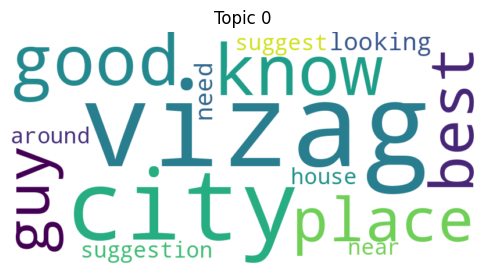

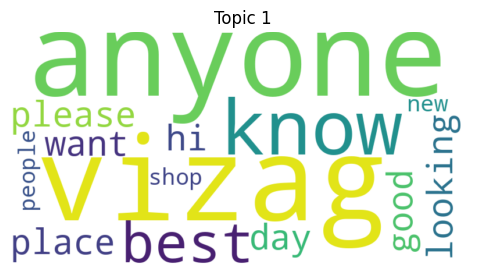

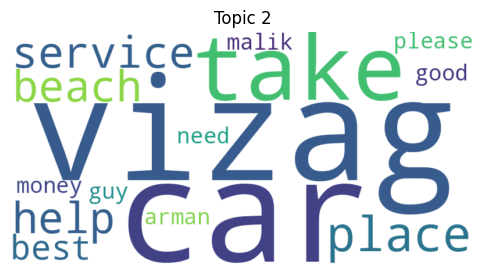

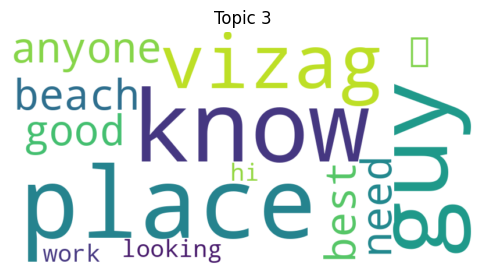

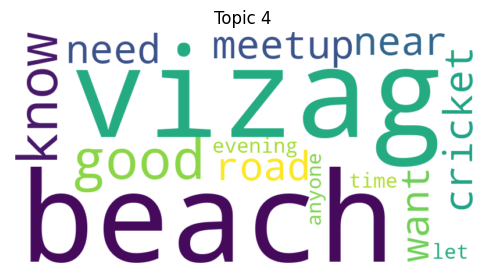

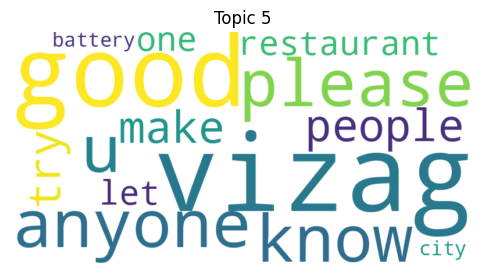

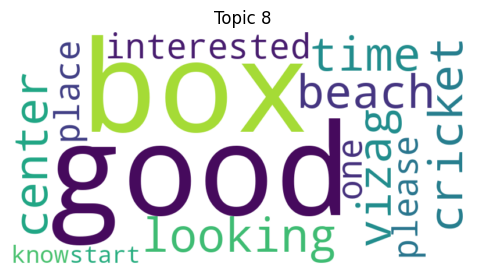

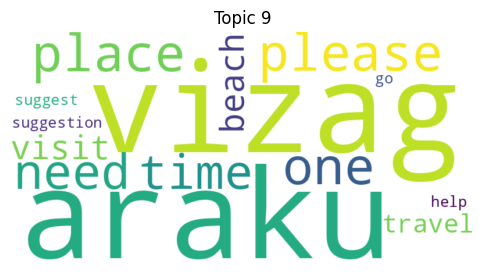

In [138]:
for topic_idx in range(vizag_lda_gensim.num_topics):
  plt.figure(figsize=(6, 6))
  topic_terms = vizag_lda_gensim.show_topic(topic_idx, topn=15)
  wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join([word for word, _ in topic_terms]))
  plt.title(f'Topic {topic_idx}')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [139]:
plot_top_words(vizag_lda_manual, vizag_tf_feature_names, 15, "Topics in LDA model")

In [140]:
# absa
raw_file_path = "/content/drive/MyDrive/Winter Project/data/New/raw_posts_visakhapatnam.json"
vizag_raw_df = json_to_df(raw_file_path) # load_reddit_json_to_df(raw_file_path)
vizag_raw_df['text'] = vizag_raw_df.apply( lambda row: semi_preprocess_text(row.title) + ". " + semi_preprocess_text(row.post), axis = 1)
vizag_raw_df['text'] = vizag_raw_df['text'].apply(replace_misspelled_words, args=(vizag_misspelled_words, vizag_correct_words))
vizag_semi_df = vizag_raw_df[['id', 'text']]
vizag_semi_df

id                                               text
0    1hapq8w  Left the city in 2006. visited once in 2015. N...
1    1hak04f  Cheap Second Hand Phone. Hello looking for a s...
2    1haj44e  Planning to sell our 25 old flat (900 sft). Wh...
3    1habvke  how to make friends in vizag?. im not new to v...
4    1ha9b17  Kittens for adoption. Hi everyone, I have a ca...
..       ...                                                ...
916  1em8q0g  The sorta sunsets that kept me sane at home du...
917  1em8mtp  Looking for swing set. Hello Vizagites. I want...
918  1em7r9n  Tulasidalam. Where can one watch the old tulas...
919  1em6fd4  Need help in finding room / PG. Hello guys, I ...
920  1em5x9s  Clash between students on road causing chaos a...

[921 rows x 2 columns]

In [141]:
vizag_semi_df = vizag_semi_df.join(vizag_df_total_topics.drop('text', axis = 1).set_index('id'), on = ['id'], how = 'left', rsuffix = '_right')
vizag_semi_df

id                                               text  \
0    1hapq8w  Left the city in 2006. visited once in 2015. N...   
1    1hak04f  Cheap Second Hand Phone. Hello looking for a s...   
2    1haj44e  Planning to sell our 25 old flat (900 sft). Wh...   
3    1habvke  how to make friends in vizag?. im not new to v...   
4    1ha9b17  Kittens for adoption. Hi everyone, I have a ca...   
..       ...                                                ...   
916  1em8q0g  The sorta sunsets that kept me sane at home du...   
917  1em8mtp  Looking for swing set. Hello Vizagites. I want...   
918  1em7r9n  Tulasidalam. Where can one watch the old tulas...   
919  1em6fd4  Need help in finding room / PG. Hello guys, I ...   
920  1em5x9s  Clash between students on road causing chaos a...   

                                          total_topics  
0    {point, dm, oo, city, details, good, anyone, p...  
1    {take, hair, city, car, places, good, help, pl...  
2    {take, books, box, city, lawsons, car, rate, g...  
3    {events, people, city, battery, buy, rk, good,...  
4    {everyone, people, city, want, battery, valley...  
..                                                 ...  
916  {people, house, want, suggest, places, good, h...  
917  {center, box, want, valley, vizagites, suggest...  
918  {hair, oo, city, places, good, anyone, please,...  
919  {oo, city, house, suggest, car, guy, good, hel...  
920  {take, chaos, city, want, tickets, clash, car,...  

[921 rows x 3 columns]

In [142]:
vizag_absa_deberta_df = perform_absa_deberta(vizag_semi_df, text_column = 'text', aspect_column='total_topics')

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


In [144]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S")
save_path = f"/content/drive/MyDrive/Winter Project/data/DF Folder/absa_deberta_visakhapatnam_{current_time}.json"
vizag_absa_deberta_df.to_json(save_path, orient='records', lines=True)

# New York

In [106]:
newyork_misspelled_words = ['ny','new york city', 'new york']
newyork_correct_words = ['nyc', 'nyc', 'nyc']

In [107]:
file_path = "/content/drive/MyDrive/Winter Project/data/New/processed_posts_newyorkcity.json"
newyork_df = pd.read_json(file_path) # load_reddit_json_to_df(file_path)
newyork_df['text'] = newyork_df['text'].apply(replace_misspelled_words, args=(newyork_misspelled_words, newyork_correct_words))
newyork_df_short = newyork_df[["id", "text"]].copy()
newyork_df_textblob = sentiment_analysis_textblob(newyork_df_short)
newyork_df_vader = sentiment_analysis_vader(newyork_df_short)
newyork_df_trans = sentiment_analysis_transformer(newyork_df_short)
newyork_df_trans

id                                               text  \
0    1haozhs  trying to find more of my heritage i am visiti...   
1    1hajakq  hey nyc firefighters from all over america nee...   
2    1hah6sq                                  we got them boys    
3    1haguoj  adams unveils 150m plan to transform 5th avenu...   
4    1hagsoq  person of interest in ceo slay id ed as school...   
..       ...                                                ...   
655  1eqrjv1  things to do for my second visit to nyc i visi...   
656  1eqr4ri  sunset park s dragon s den unveils mural as el...   
657  1eqm3ga  i just realized nyc was founded in 1624 meanin...   
658  1eqkozq  randall s island migrant shelter plagued by un...   
659  1eqfg6k  mc s poets musicians singers songwriters dance...   

    transformer_sentiment  
0                Negative  
1                Positive  
2                Positive  
3                Positive  
4                Negative  
..                    ...  
655              Positive  
656              Positive  
657              Negative  
658              Negative  
659              Positive  

[660 rows x 3 columns]

In [108]:
newyork_df_gensim, newyork_lda_gensim, newyork_dictionary_gensim = topic_modeling_lda_gensim(newyork_df_short, num_topics=10)
newyork_lda_genism = format_lda_genism_to_df(newyork_lda_gensim.show_topics(num_topics=10, num_words=15, log=False, formatted=False))
newyork_df_lda = newyork_df_gensim.join(newyork_lda_genism.set_index('lda_genism_topic'), on = ['lda_genism_topic'], how = 'left', rsuffix = '')

newyork_df_lda, newyork_lda_manual, newyork_vectorizer_lda_manual = topic_modeling_manual(newyork_df_lda, num_topics=10)
newyork_tf_feature_names = newyork_vectorizer_lda_manual.get_feature_names_out()
newyork_df_lda_manual = format_lda_manual_to_df(newyork_lda_manual, newyork_tf_feature_names, top_n_words_per_topic=15)
newyork_df_lda = newyork_df_lda.join(newyork_df_lda_manual.set_index('lda_manual_topic'), on = ['lda_manual_topic'], how = 'left', rsuffix = '')

newyork_df_total_topics = extract_nouns(newyork_df_lda)

newyork_df_total_topics['total_topics'] = newyork_df_total_topics.apply(lambda row: row.topics.union(row.nouns).union(row.terms), axis = 1)
newyork_df_total_topics = newyork_df_total_topics.drop(['lda_manual_topic', 'lda_genism_topic', 'nouns', 'topics', 'terms'], axis = 1)
newyork_df_total_topics['total_topics'] = newyork_df_total_topics['total_topics'].apply(remove_one_letter_words)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [112]:
all_unique_topics = set().union(*newyork_df_total_topics['total_topics'])
print(len(all_unique_topics))
all_unique_topics

2681


{'metro',
 'gay',
 'city',
 'mike',
 'vote',
 'justin',
 'archivist',
 'cottage',
 'images',
 'thomas',
 'ny1',
 'context',
 'task',
 'type',
 'coffees',
 'sunday',
 'wednesday',
 'iconic',
 'zero',
 'heroism',
 'sounds',
 'stamps',
 'climate',
 'nurses',
 'loud',
 'mile',
 'beach',
 'fight',
 'commissioner',
 'yourselves',
 'tip',
 'discoloration',
 'committee',
 'shootings',
 'lewis',
 'bills',
 'rip',
 'region',
 'developments',
 'procedures',
 'survive',
 'shit',
 'saw',
 '___________',
 'flights',
 'incentive',
 'professionals',
 'restrooms',
 'bullshit',
 'submissions',
 'pickleball',
 'highlights',
 'world',
 'rats',
 'tens',
 'data',
 'mayor',
 'seizures',
 'weight',
 'rooftop',
 'view',
 'ballotpedia',
 'fans',
 'decency',
 'foodies',
 'let',
 'back',
 'enigma',
 'nation',
 'empire',
 'knowledges',
 'lincoln',
 'sauces',
 'authenticity',
 'yards',
 'heads',
 'thoughts',
 'pesticide',
 'official',
 'campus',
 'carr',
 'eastern',
 'goal',
 'password',
 'valedictorian',
 'paradis

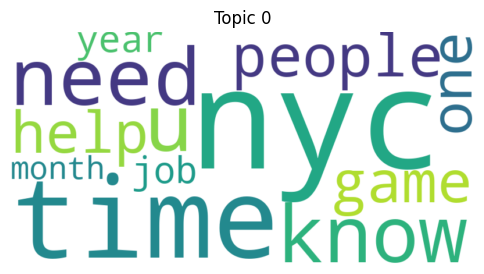

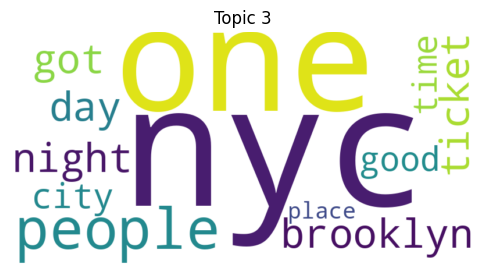

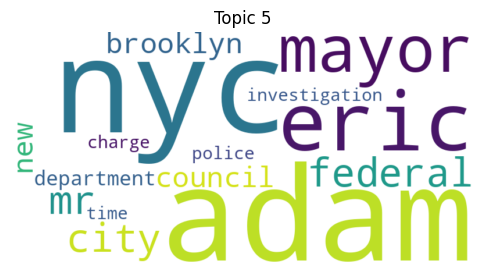

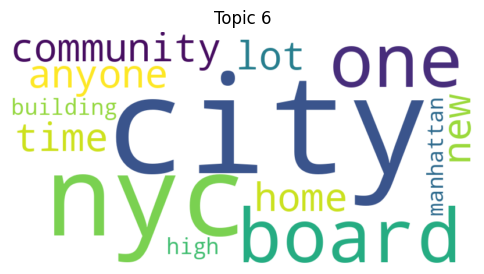

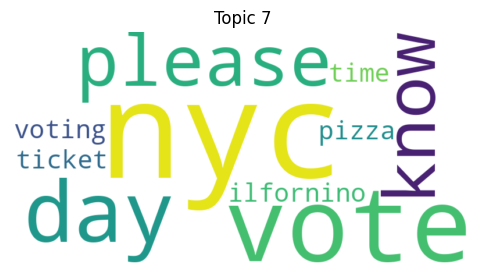

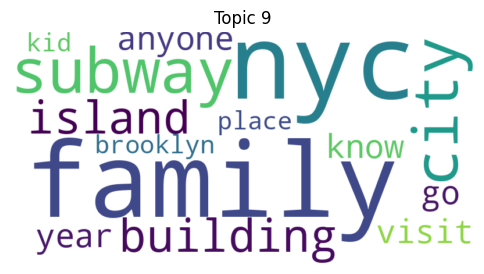

In [110]:
for topic_idx in range(newyork_lda_gensim.num_topics):
  plt.figure(figsize=(6, 6))
  topic_terms = newyork_lda_gensim.show_topic(topic_idx, topn=15)
  wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join([word for word, _ in topic_terms]))
  plt.title(f'Topic {topic_idx}')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

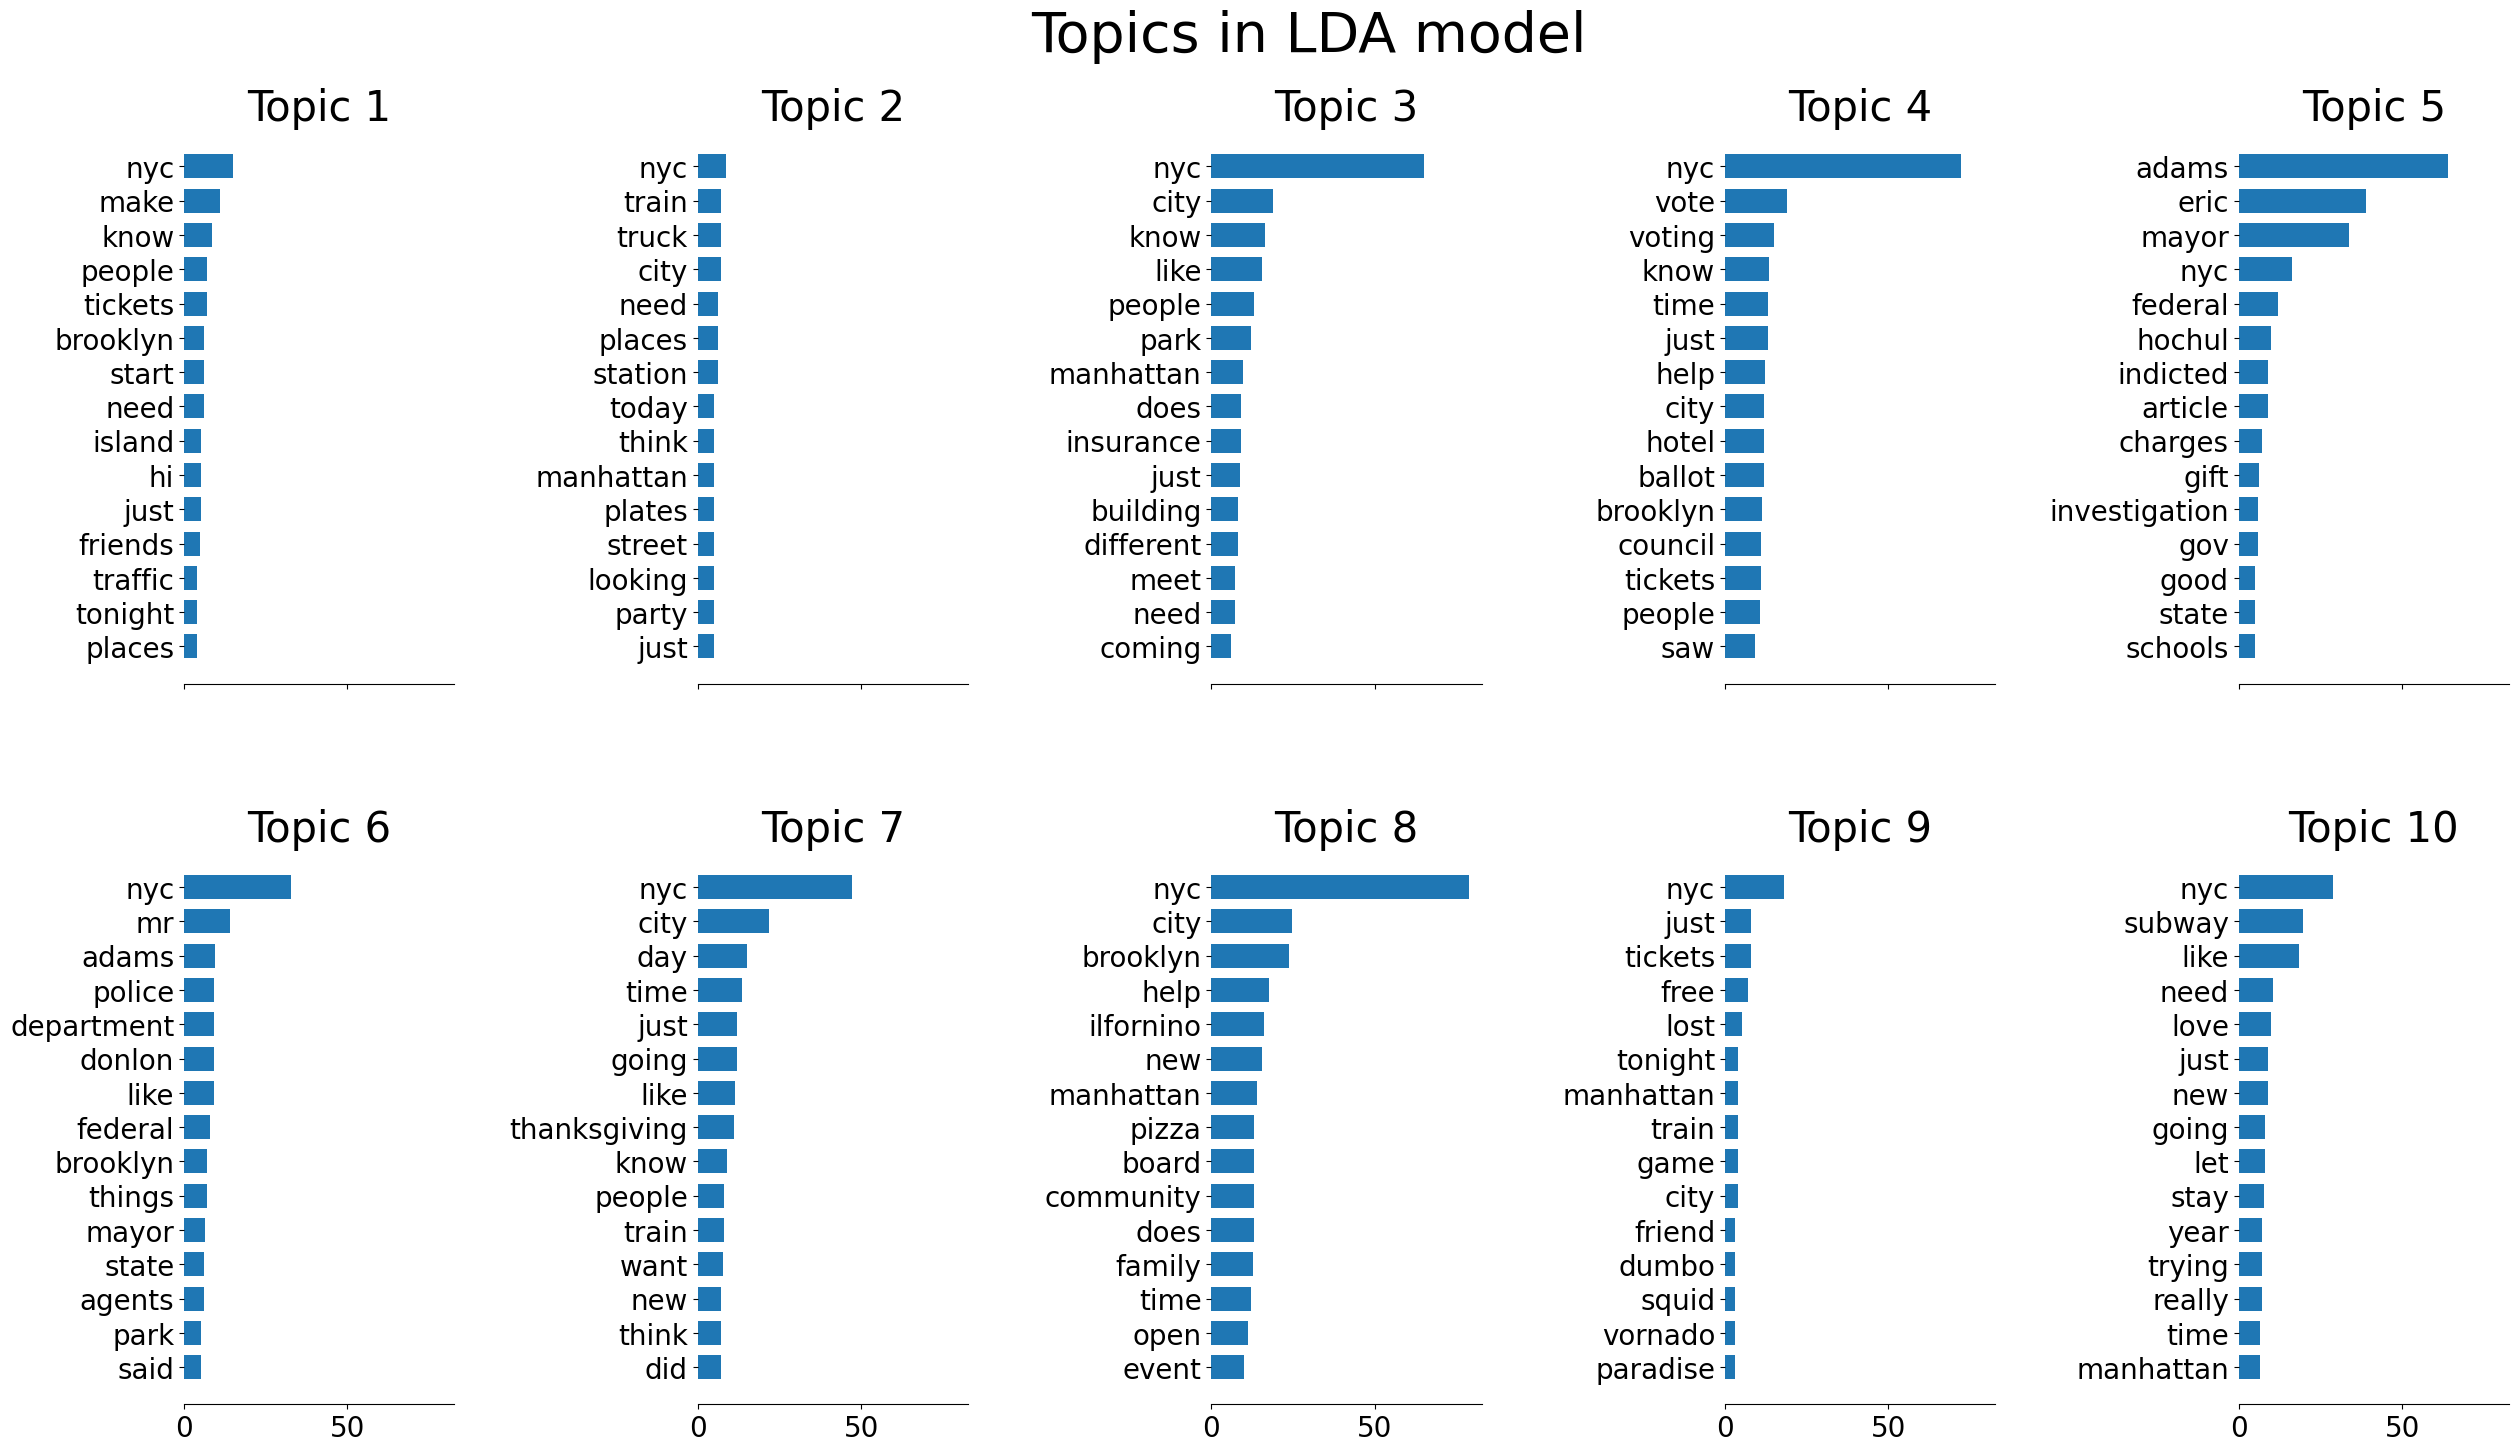

In [111]:
plot_top_words(newyork_lda_manual, newyork_tf_feature_names, 15, "Topics in LDA model")

In [113]:
# absa
raw_file_path = "/content/drive/MyDrive/Winter Project/data/New/raw_posts_newyorkcity.json"
newyork_raw_df = json_to_df(raw_file_path) # load_reddit_json_to_df(raw_file_path)
newyork_raw_df['text'] = newyork_raw_df.apply( lambda row: semi_preprocess_text(row.title) + ". " + semi_preprocess_text(row.post), axis = 1)
newyork_raw_df['text'] = newyork_raw_df['text'].apply(replace_misspelled_words, args=(newyork_misspelled_words, newyork_correct_words))
newyork_semi_df = newyork_raw_df[['id', 'text']]
newyork_semi_df

id                                               text
0    1haozhs  Trying to find more of my heritage. Im visitin...
1    1hajakq  Hey nyc, Firefighters from all over America ne...
2    1hah6sq                                   We got em boys. 
3    1haguoj  \Adams unveils $150M plan to transform 5th Ave...
4    1hagsoq  Person of Interest in CEO Slay ID'ed as School...
..       ...                                                ...
655  1eqrjv1  Things to do for my second visit to nyc. I vis...
656  1eqr4ri  Sunset Park’s ‘Dragon’s Den’ unveils mural as ...
657  1eqm3ga  I just realized, nyc was founded in 1624 meani...
658  1eqkozq  Randall's Island migrant shelter plagued by un...
659  1eqfg6k  MC's, Poets, Musicians, Singers, Songwriters, ...

[660 rows x 2 columns]

In [114]:
newyork_semi_df = newyork_semi_df.join(newyork_df_total_topics.drop('text', axis = 1).set_index('id'), on = ['id'], how = 'left', rsuffix = '_right')
newyork_semi_df

id                                               text  \
0    1haozhs  Trying to find more of my heritage. Im visitin...   
1    1hajakq  Hey nyc, Firefighters from all over America ne...   
2    1hah6sq                                   We got em boys.    
3    1haguoj  \Adams unveils $150M plan to transform 5th Ave...   
4    1hagsoq  Person of Interest in CEO Slay ID'ed as School...   
..       ...                                                ...   
655  1eqrjv1  Things to do for my second visit to nyc. I vis...   
656  1eqr4ri  Sunset Park’s ‘Dragon’s Den’ unveils mural as ...   
657  1eqm3ga  I just realized, nyc was founded in 1624 meani...   
658  1eqkozq  Randall's Island migrant shelter plagued by un...   
659  1eqfg6k  MC's, Poets, Musicians, Singers, Songwriters, ...   

                                          total_topics  
0    {city, voting, vote, nyc, ilfornino, californi...  
1    {america, brooklyn, people, city, voting, saw,...  
2    {brooklyn, people, city, voting, saw, vote, ny...  
3    {plan, brooklyn, boulevard, people, city, voti...  
4    {brooklyn, people, school, city, traffic, nyc,...  
..                                                 ...  
655  {center, brooklyn, people, park, evenings, cit...  
656  {brooklyn, sunset, people, park, city, meet, n...  
657  {brooklyn, people, birthday, city, traffic, ny...  
658  {article, gift, city, nyc, investigation, good...  
659  {painters, people, city, nyc, train, plates, p...  

[660 rows x 3 columns]

In [115]:
newyork_absa_deberta_df = perform_absa_deberta(newyork_semi_df, text_column = 'text', aspect_column='total_topics')

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


In [116]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S")
save_path = f"/content/drive/MyDrive/Winter Project/data/DF Folder/absa_deberta_newyork_{current_time}.json"
newyork_absa_deberta_df.to_json(save_path, orient='records', lines=True)